**NER**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [13]:
raot_cta_ner = pd.read_csv('ner_data.csv')
print(raot_cta_ner['ID'].nunique())
raot_cta_ner.head()

18523


,SURVEY_DATE,ID,NAME,STATE,CITY,MSA,SUBMARKET,CONSTRUCTION_TYPE,UNITS,NER
0,2017-09-18,57c701a1e650b70e00e31788,Villas at Shadow Creek Ranch,TX,Pearland,"Houston, TX",Brazoria County,Garden,560,1345.794642
1,2020-01-07,5ddc1efb669c31001d0288e3,Avail,CO,Aurora,"Denver, CO",Aurora-South,Garden,424,1727.790094
2,2020-10-04,5f6ba6deb8caa50003512f3d,Harmony 3900,UT,South Salt Lake,"Salt Lake City, UT",South Salt Lake/Cottonwood,Garden,285,1267.214035
3,2020-10-05,5cd3047060d93b001521eb6c,Lennox SouthPark Apartments,NC,Charlotte,"Charlotte, NC",Carmel,Mid-rise,239,1454.866108
4,2021-09-03,5e62b82b8c00b0001dd22b25,Portofino Landings,FL,Fort Pierce,"Port St. Lucie, FL",Other,Garden,236,1672.932203


In [14]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [15]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,SURVEY_DATE,ID,NAME,STATE,CITY,MSA,SUBMARKET,CONSTRUCTION_TYPE,UNITS,NER,WEEK_START
643506,2022-08-14,5aa146b5f32106001344bf1c,Artisan on 2nd Apartments,CA,Los Angeles,"Los Angeles, CA",Downtown,Mid-rise,118,3145.491525,2022-08-08
1140038,2022-08-14,5ddf17ed2adebb001d2c5f84,Signature Pointe Apartments,WA,Kent,"Seattle, WA",Des Moines/West Kent,Garden,628,2115.331210,2022-08-08
421512,2022-08-14,5642c17f55d27c0e003b6684,Stanford West,CA,Palo Alto,"San Jose, CA",Mountain View/Los Altos,Garden,628,3290.608280,2022-08-08
649983,2022-08-14,6202a2a8dbac13002a817c45,West Village,CA,San Jose,"San Jose, CA",Central San Jose,Garden,164,2111.195121,2022-08-08
800364,2022-08-14,5dfa6c65276c95001dc79cba,Talia Apartments,MA,Marlborough,"Boston, MA",West/Northwest Suburban,Mid-rise,225,2573.173333,2022-08-08


## XGBOOST

In [16]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['STATE']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER')

In [17]:
print(list(subsets.keys())[0])
list(subsets.values())[0]

AL


,UNITS,NER
WEEK_START,,
2017-10-02,497.583333,601.455573
2017-10-09,271.333333,1036.293628
2017-10-16,271.333333,1005.216468
2017-10-23,407.636364,904.376015
2017-10-30,250.000000,1015.873537
...,...,...
2022-07-11,292.346939,1431.879771
2022-07-18,293.186441,1428.724266
2022-07-25,243.432432,1299.919598


In [18]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [19]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [20]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [21]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [22]:
def evaluation(test_data, predictions):
    mape = mean_absolute_percentage_error(predictions, test_data)
    return mape

[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[20:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1

ValueError: Wrong number of items passed 0, placement implies 1

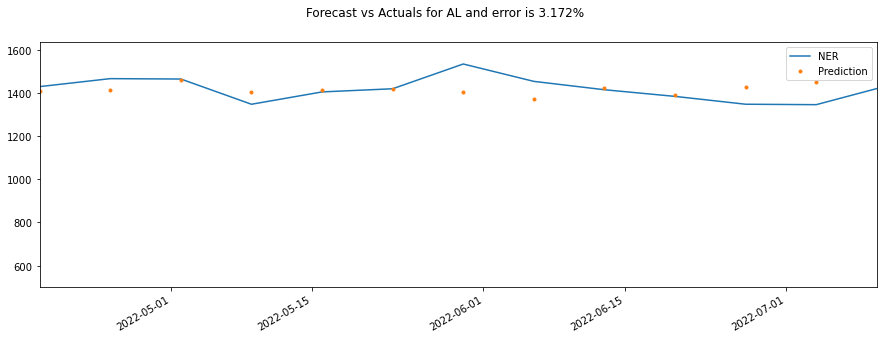

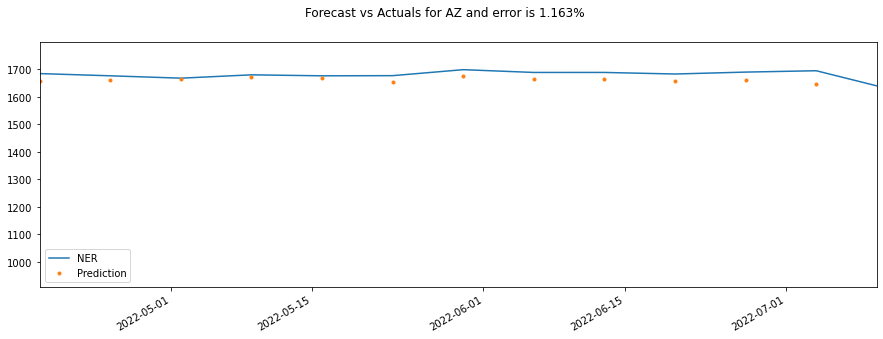

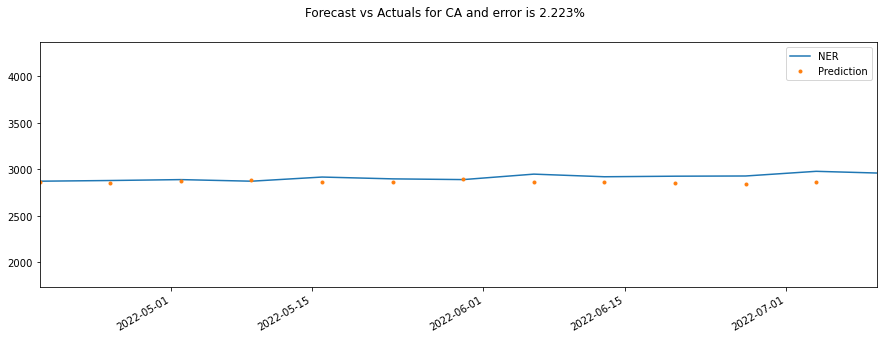

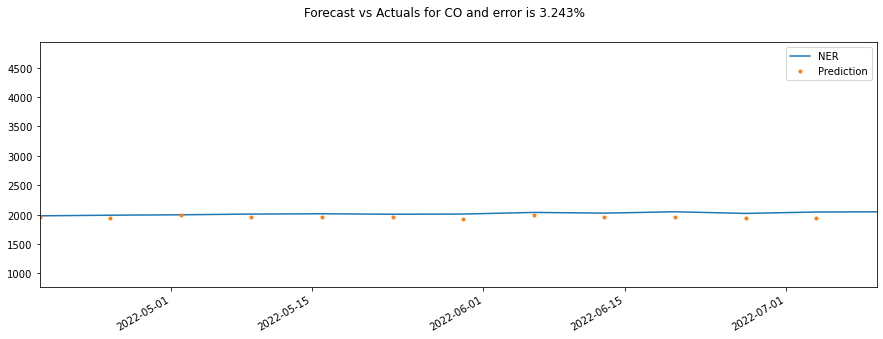

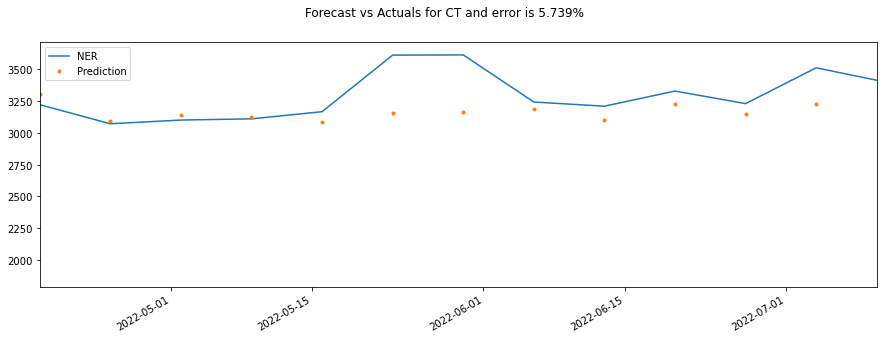

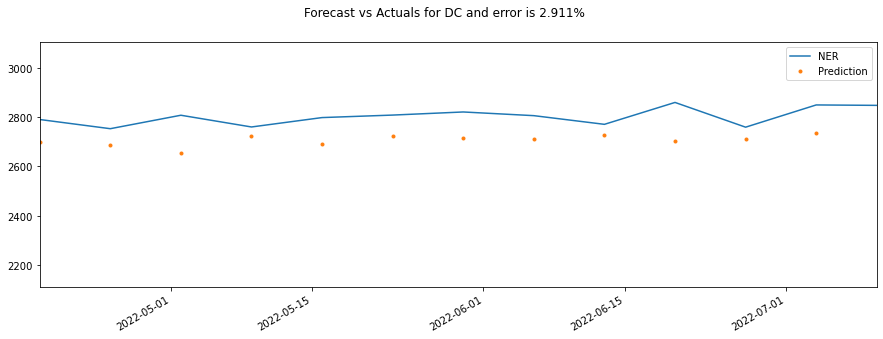

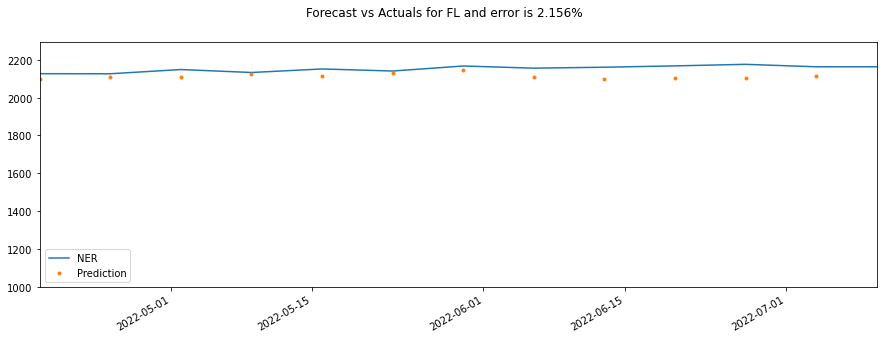

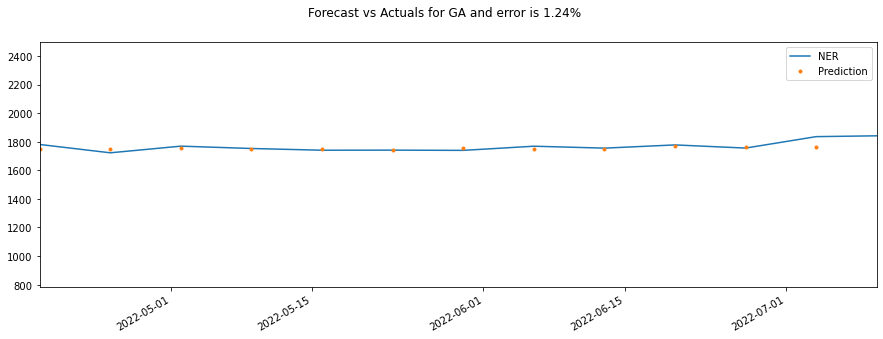

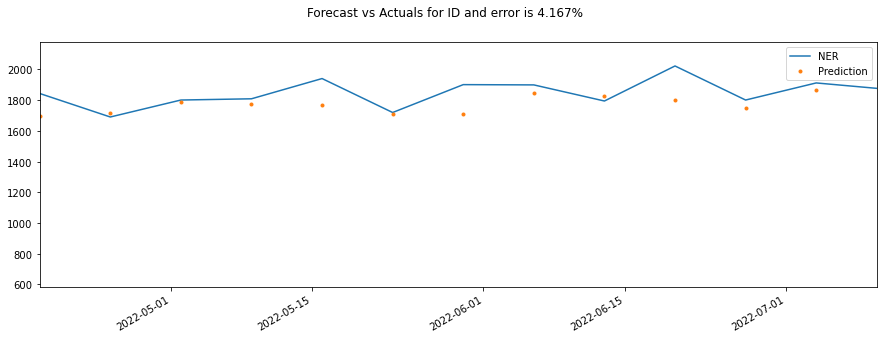

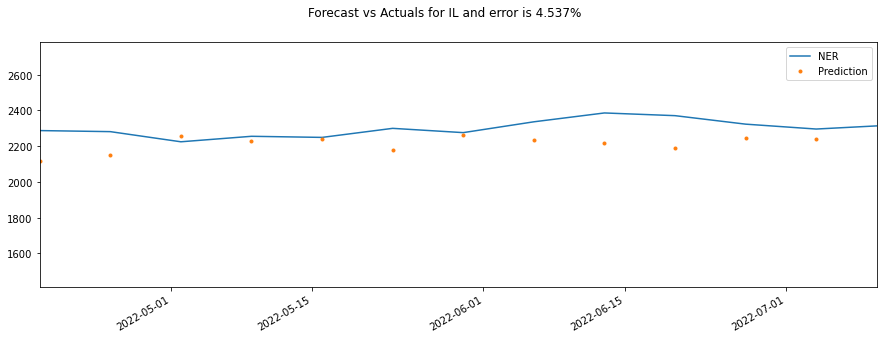

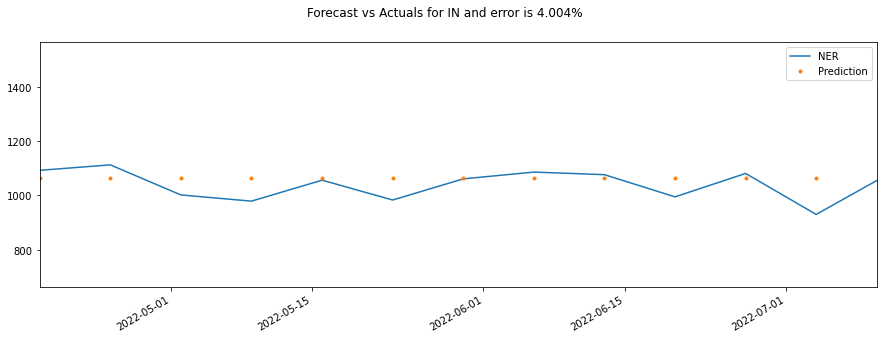

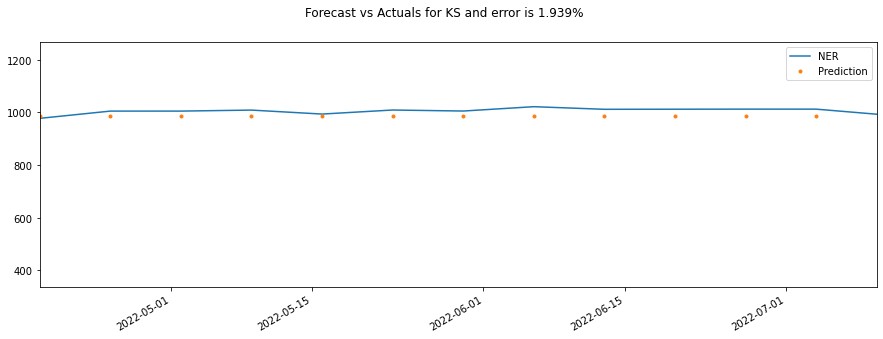

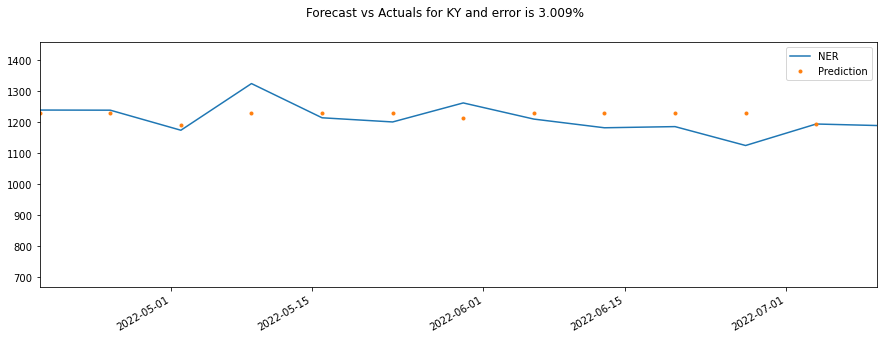

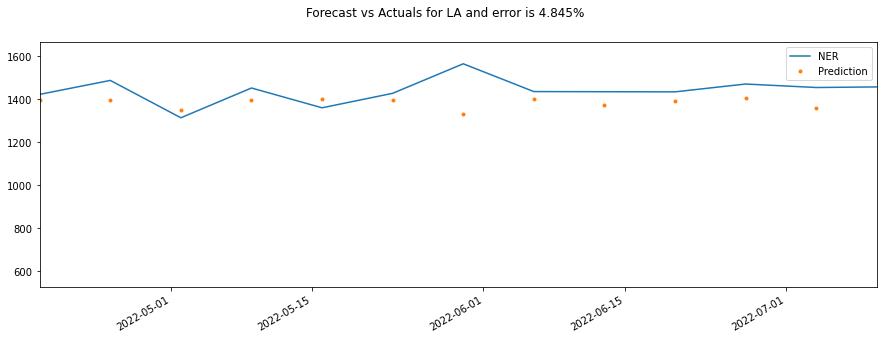

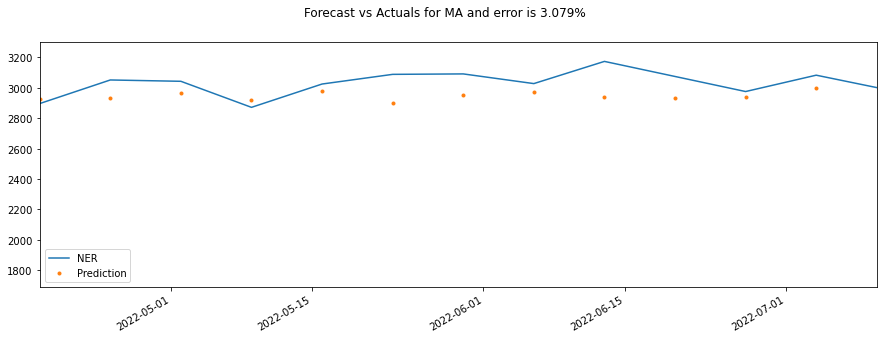

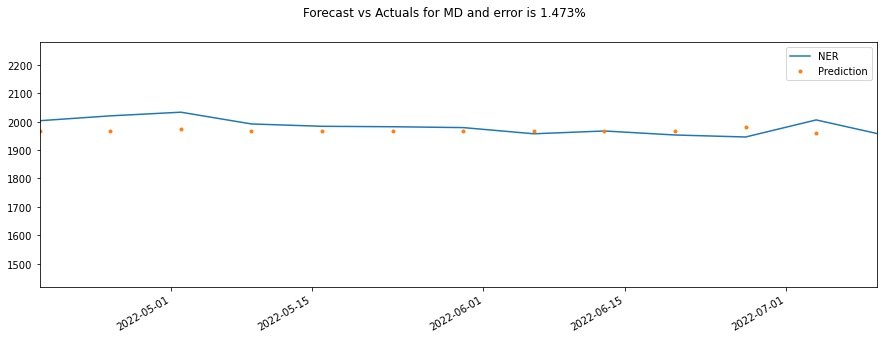

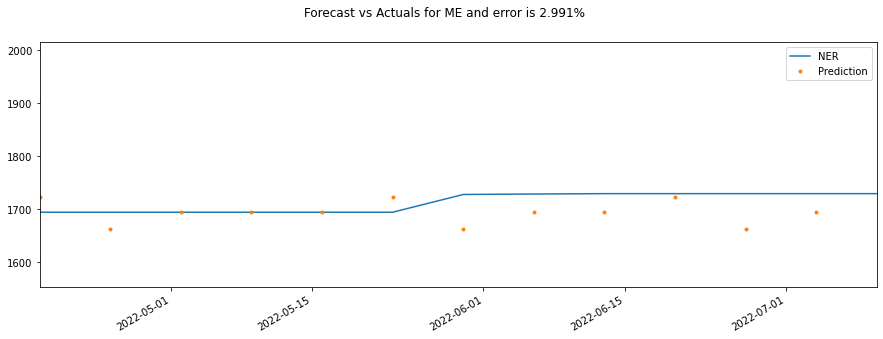

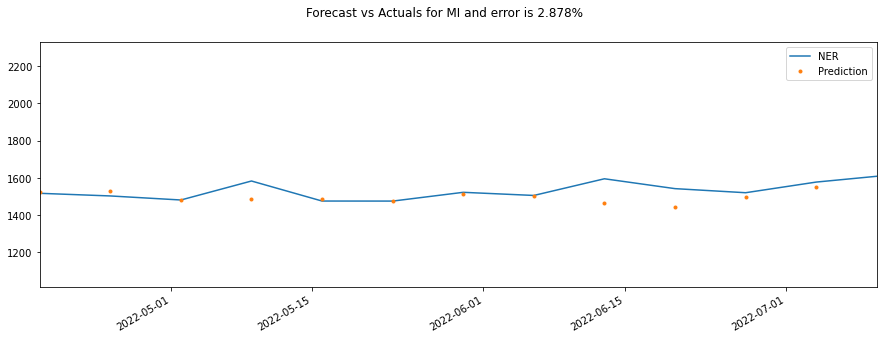

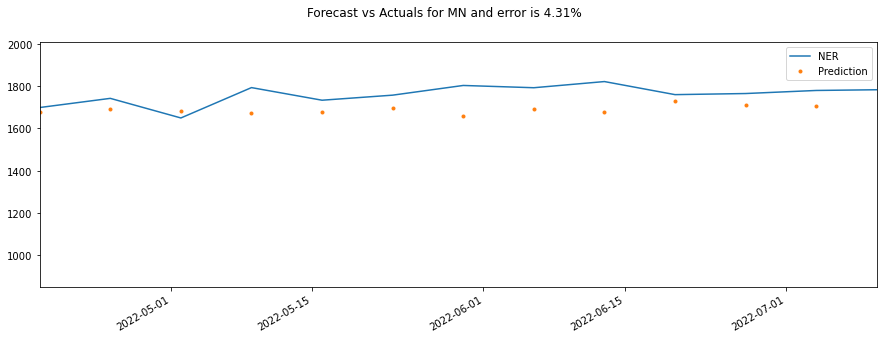

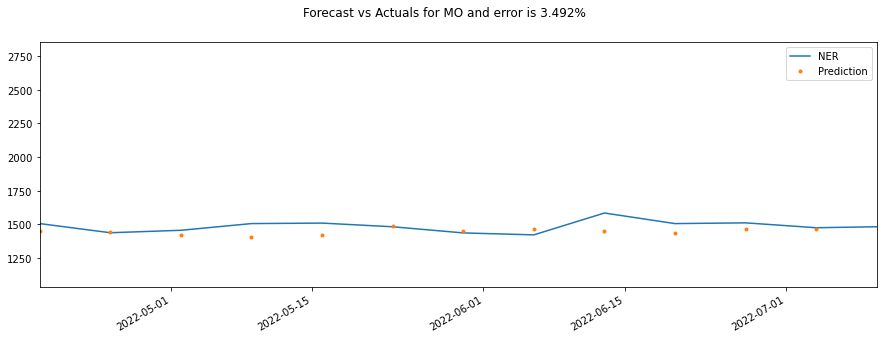

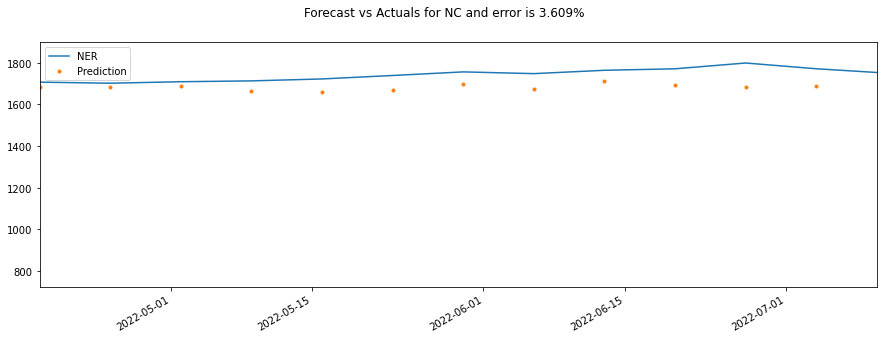

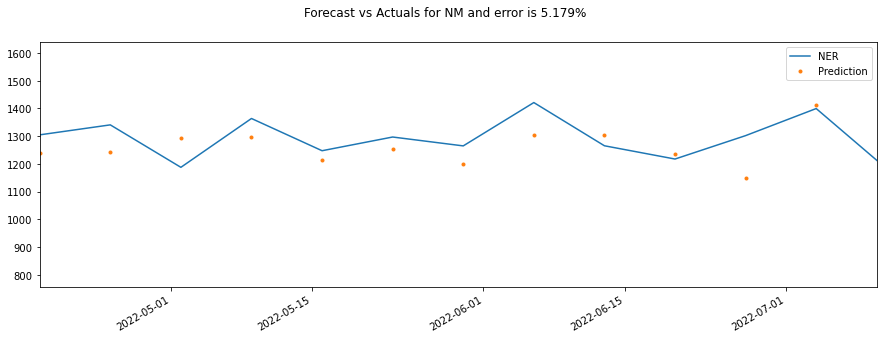

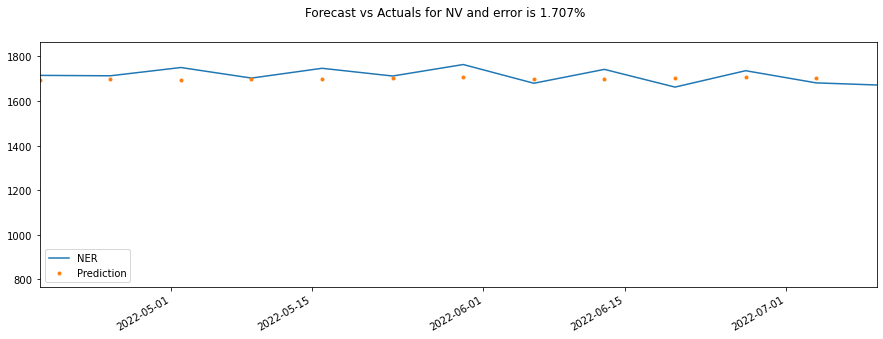

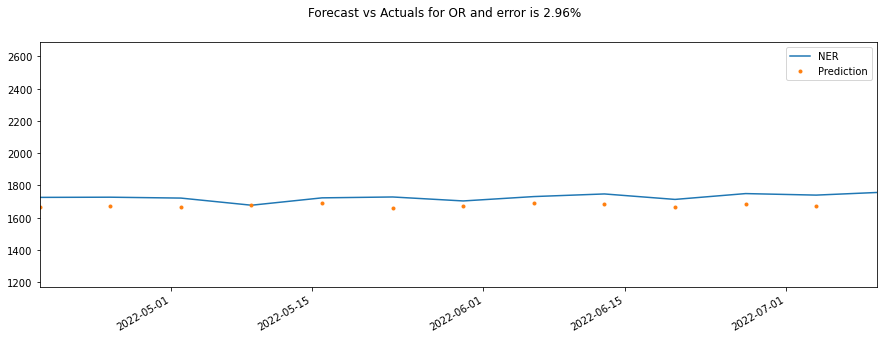

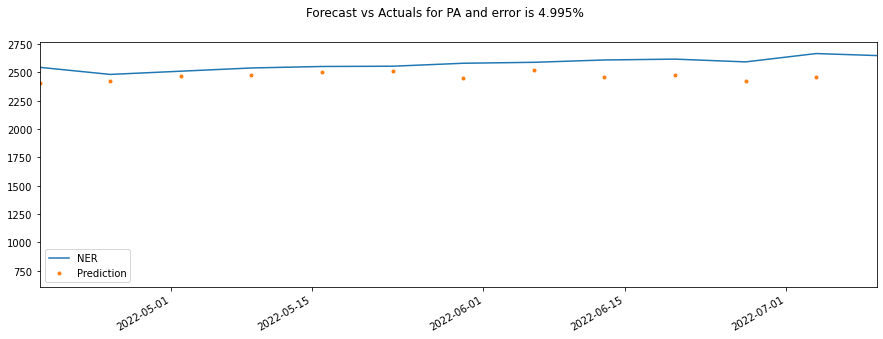

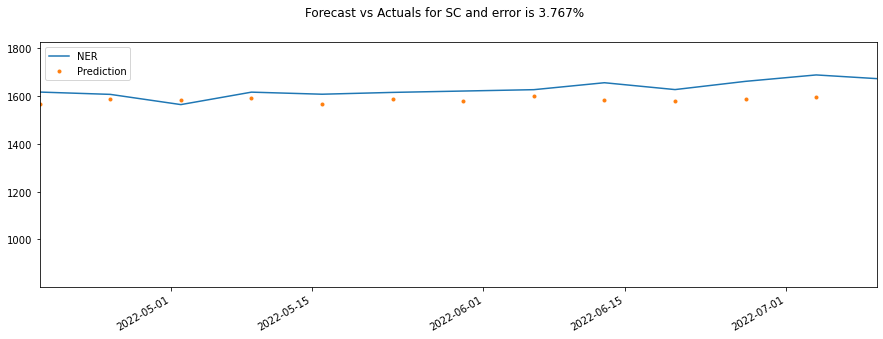

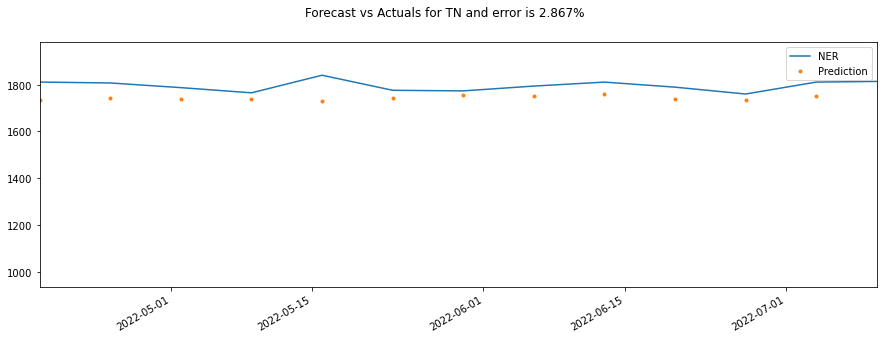

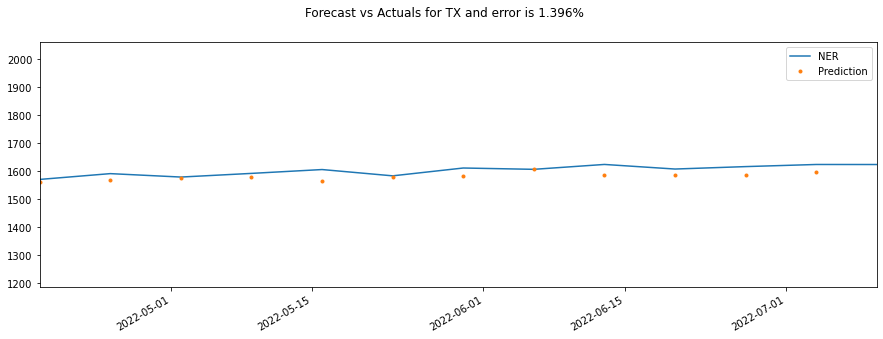

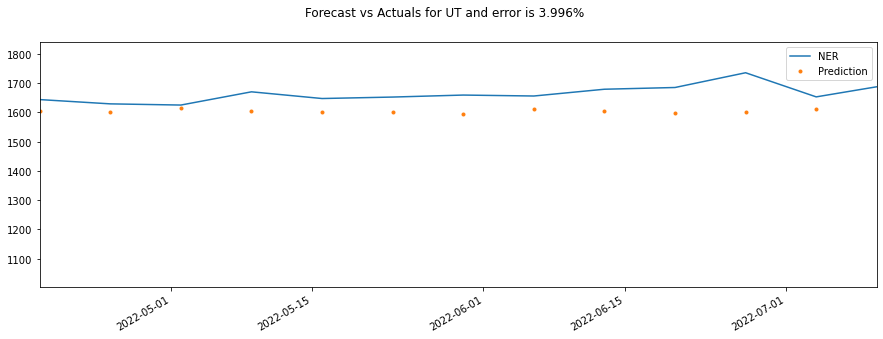

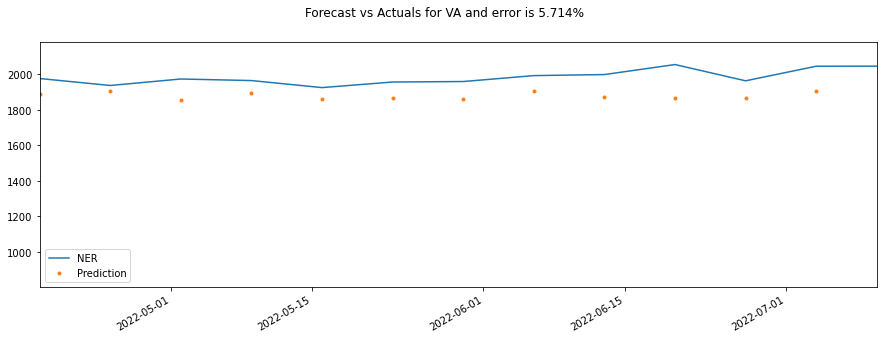

In [23]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 4, 4)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER')
    X_test, y_test = create_features(df_test, label='NER')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    mape = evaluation(df_test['NER'], df_test['Prediction'])
    
    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='04-18-2022', upper='07-10-2022')
        ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

        mape = evaluation(df_test['NER'], df_test['Prediction'])
        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

ValueError: Wrong number of items passed 0, placement implies 1

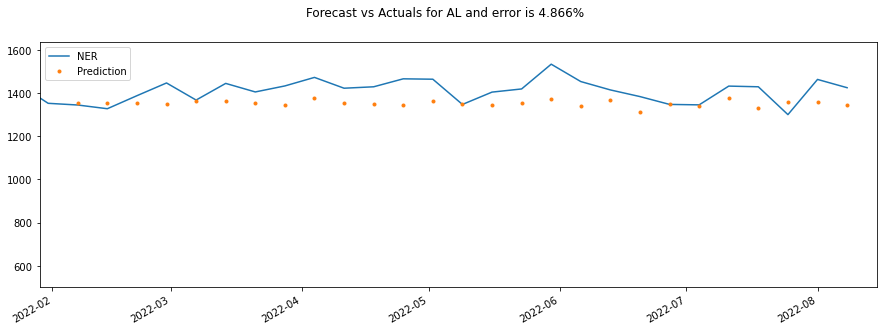

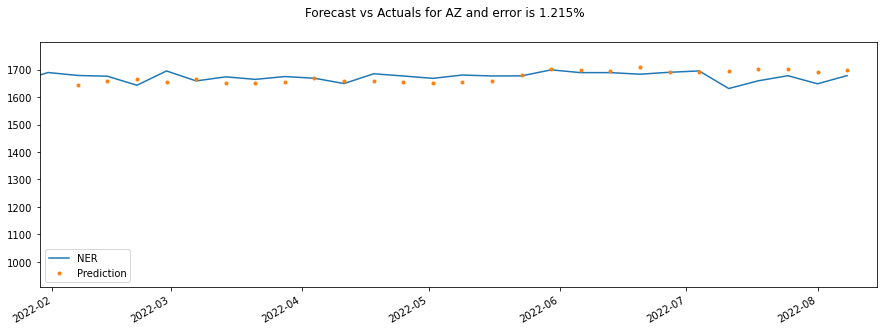

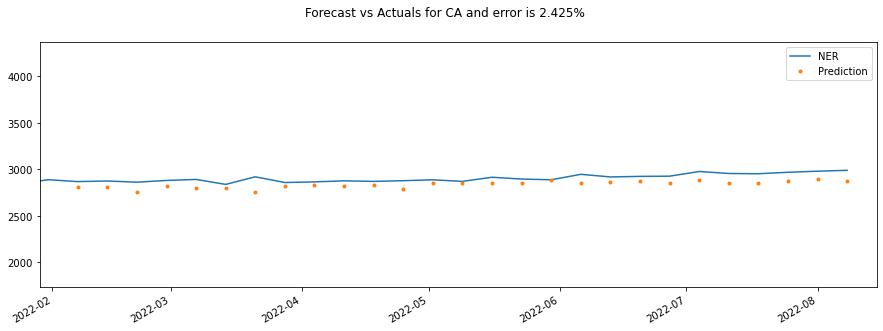

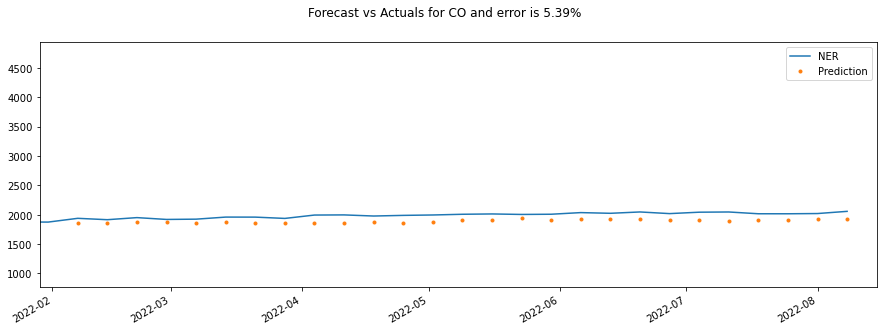

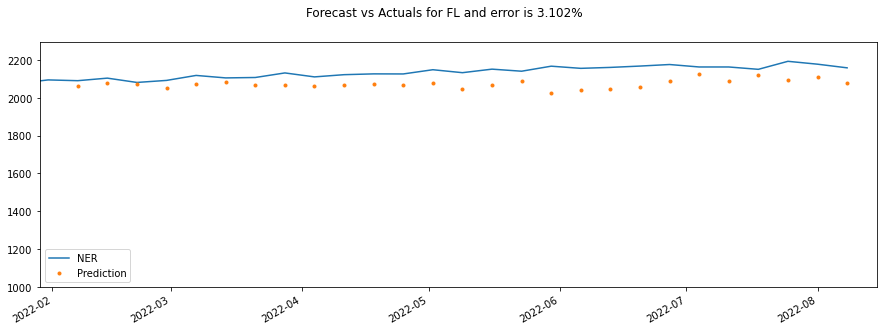

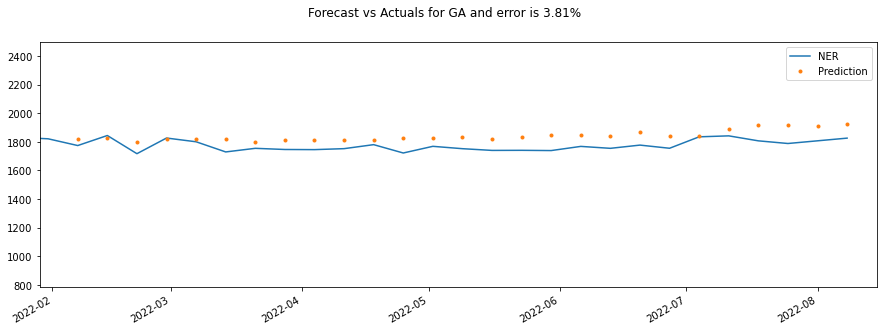

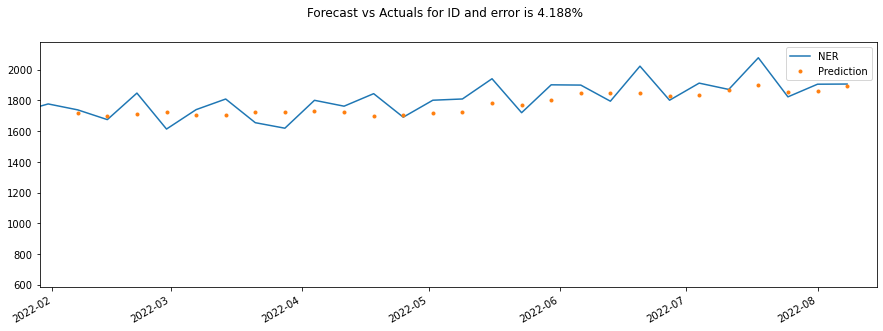

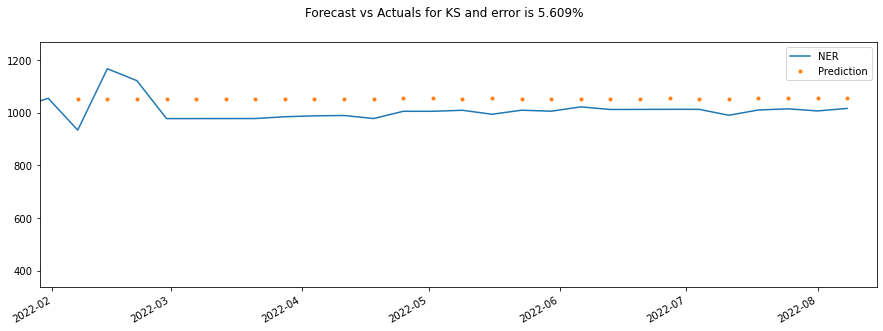

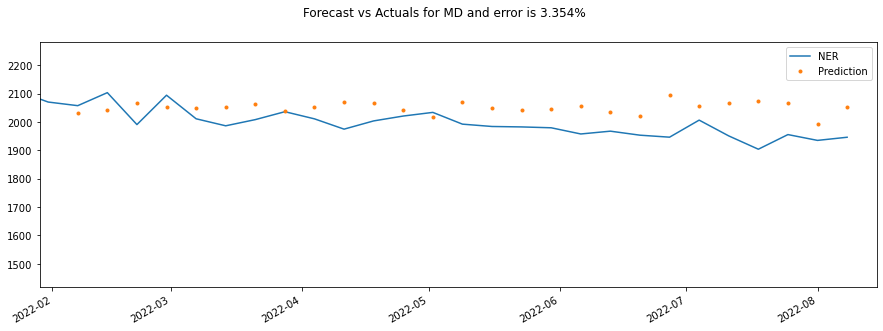

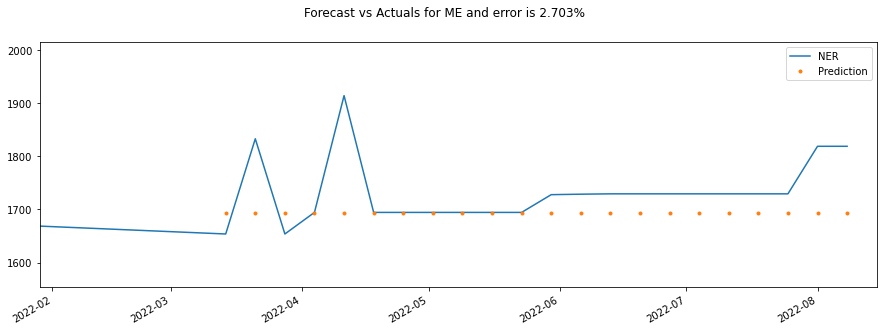

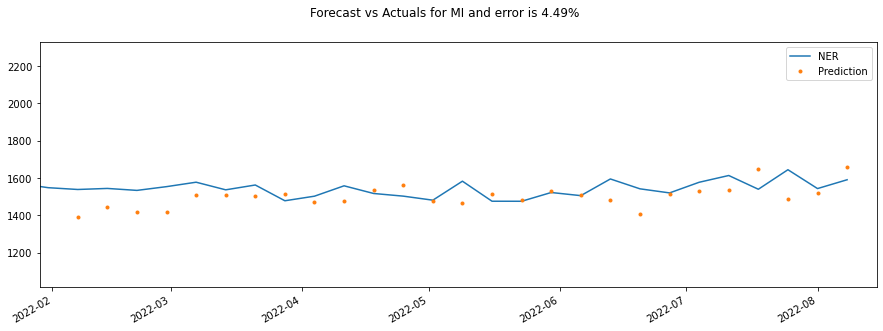

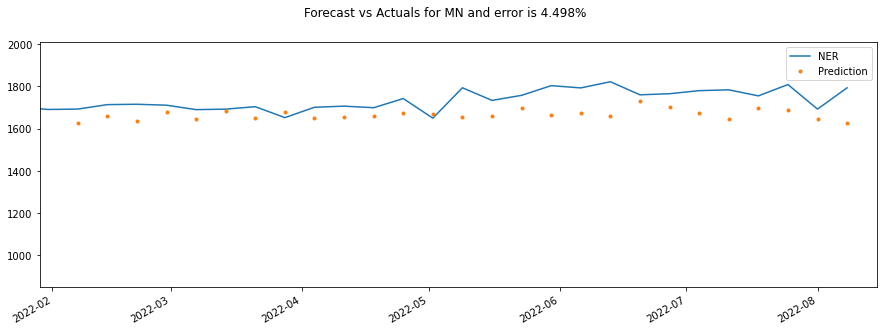

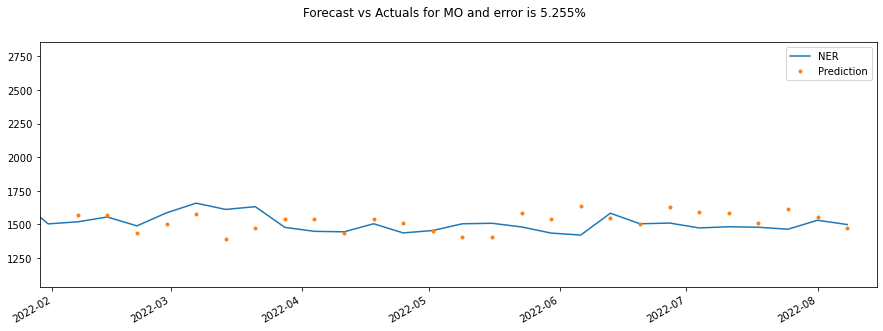

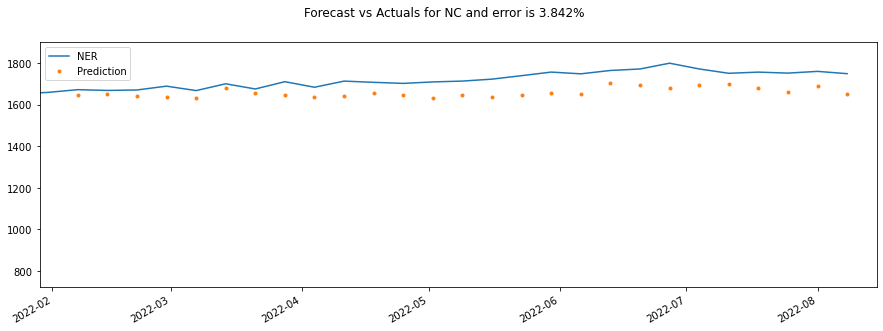

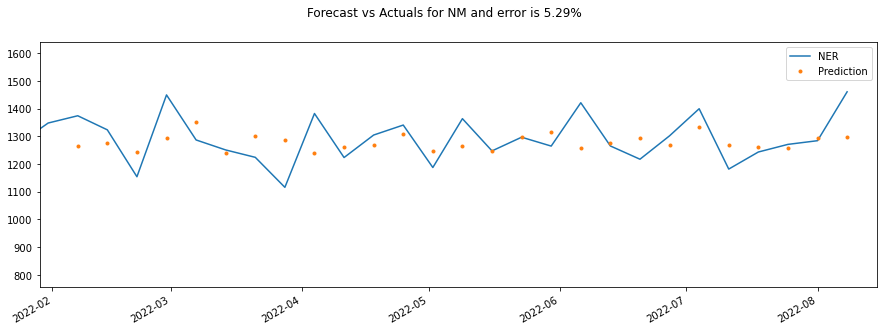

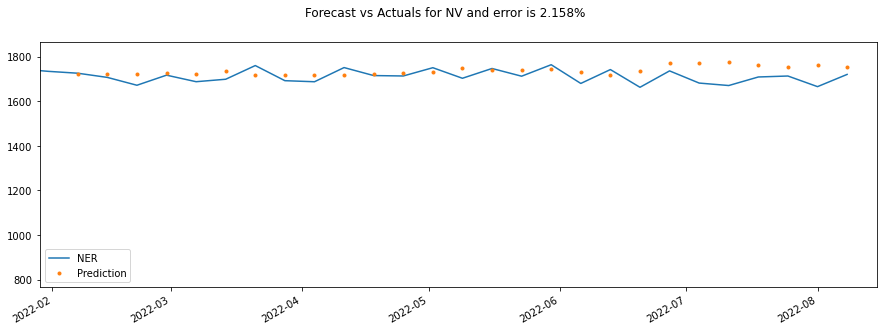

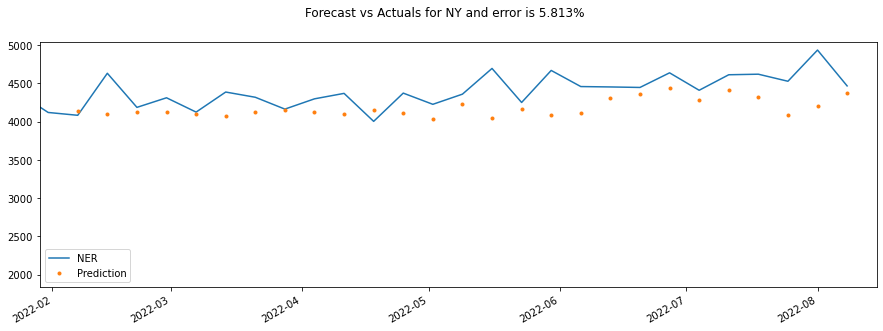

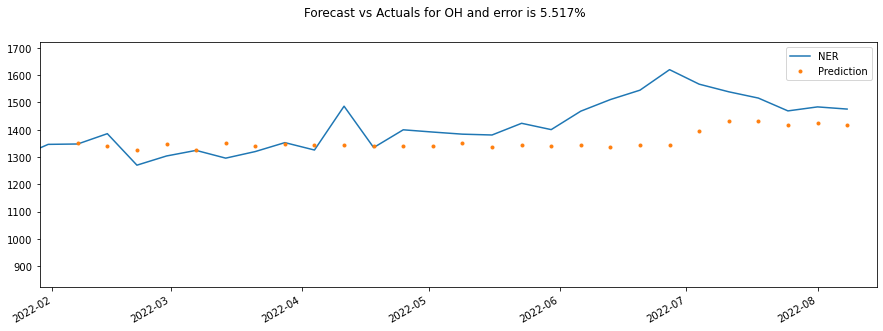

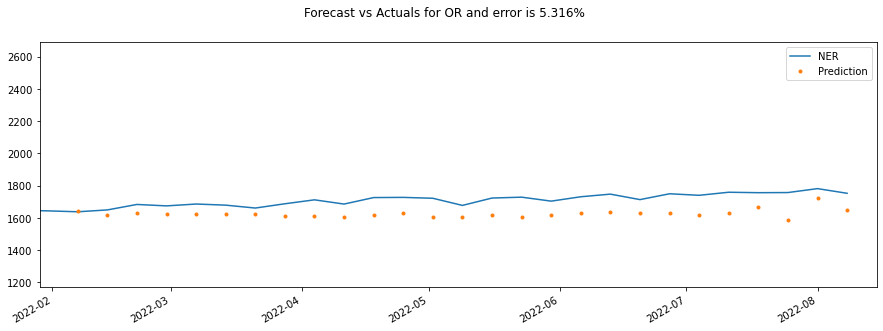

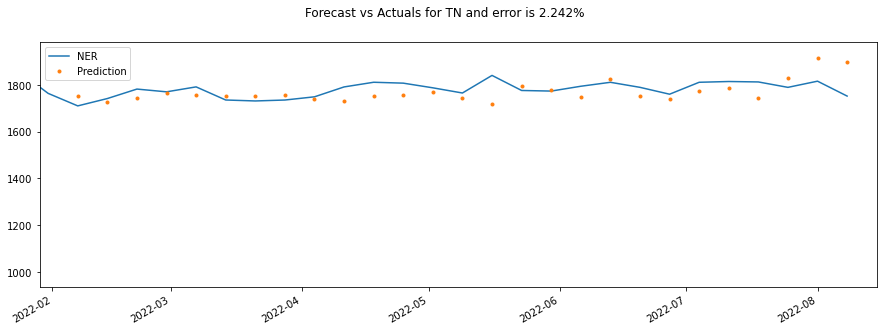

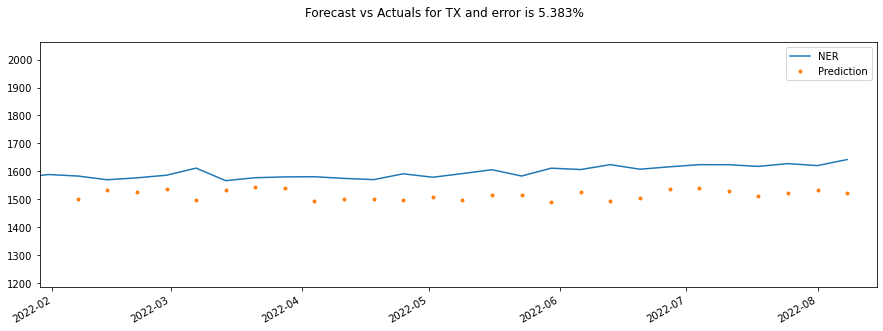

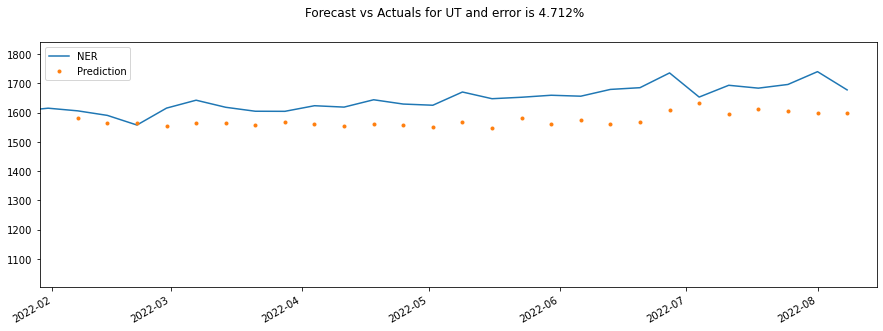

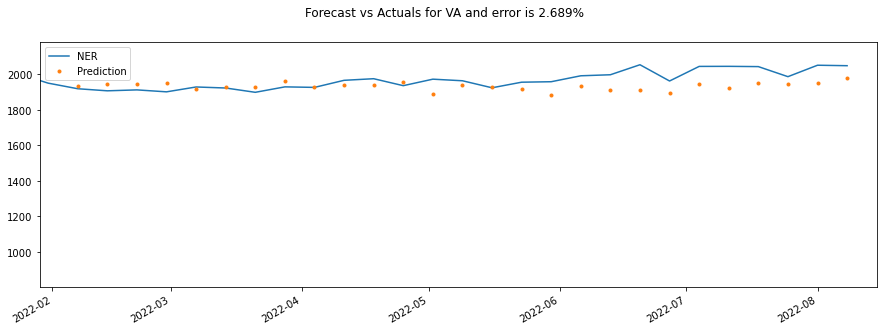

In [24]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 2, 1)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER')
    
    X_test, y_test = create_features(df_test, label='NER')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    mape = evaluation(df_test['NER'], df_test['Prediction'])

    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
        ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

In [25]:
prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
prediction_period = prediction_period.rename(columns = {0:'date'})
prediction_period

,date
0,2022-08-14
1,2022-08-21
2,2022-08-28
3,2022-09-04
4,2022-09-11
5,2022-09-18
6,2022-09-25
7,2022-10-02
8,2022-10-09
9,2022-10-16


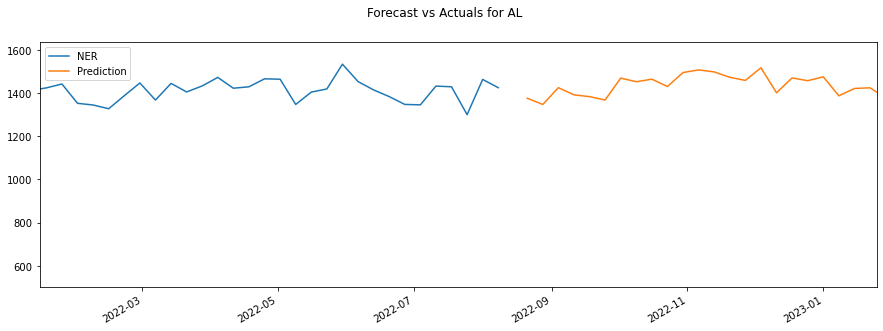

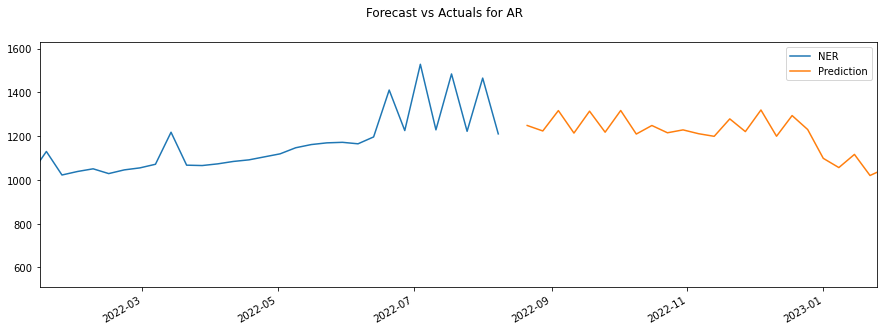

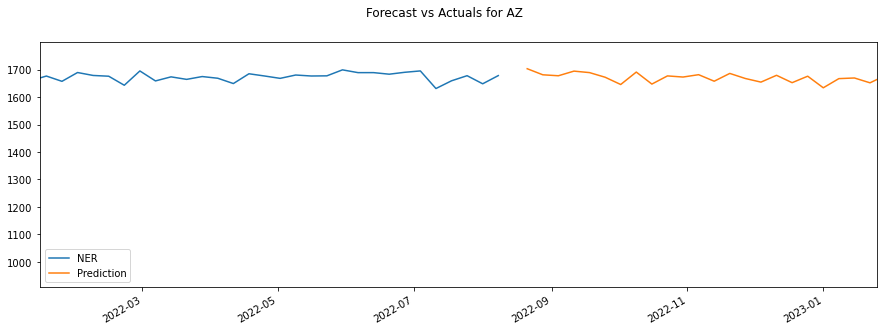

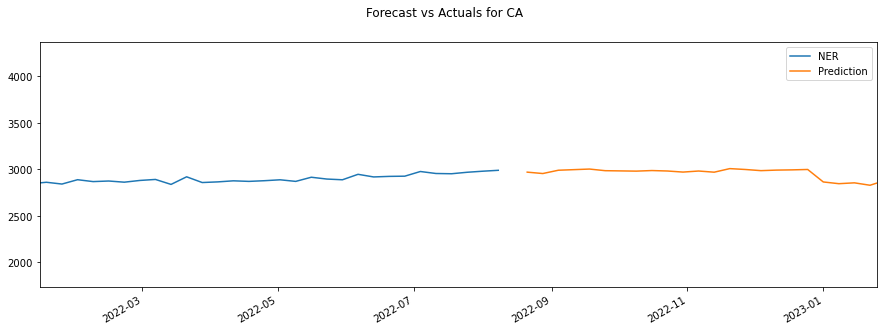

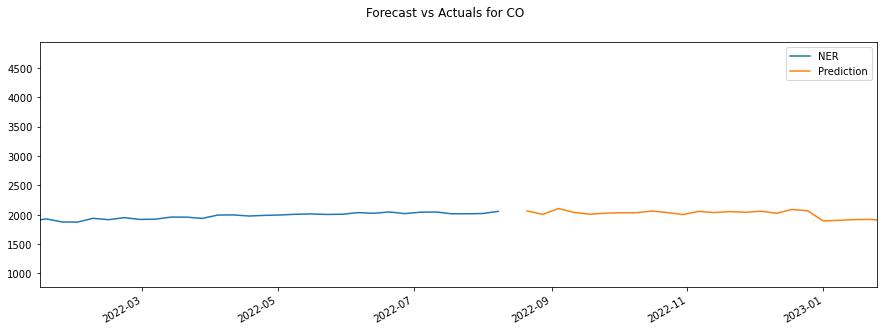

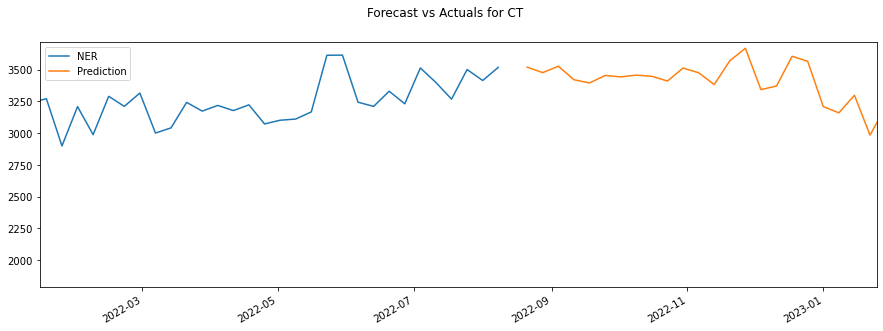

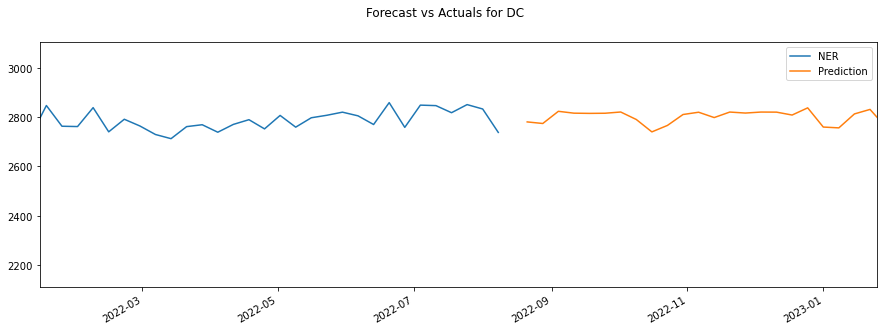

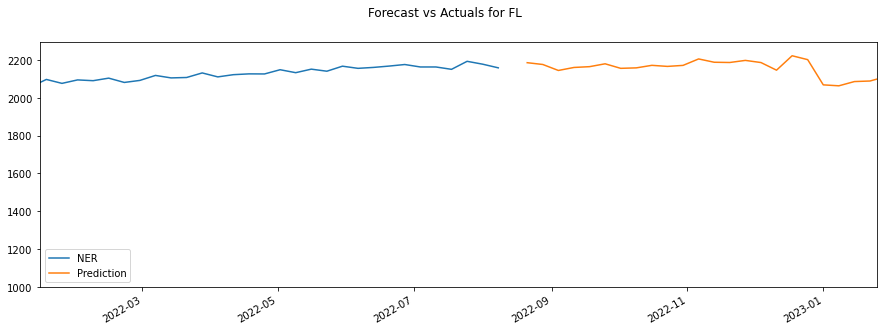

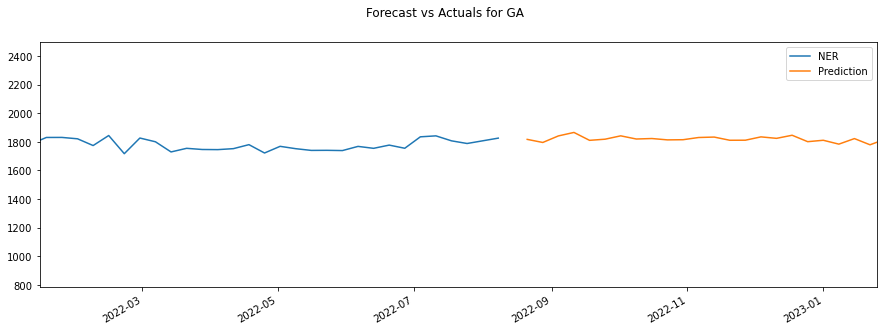

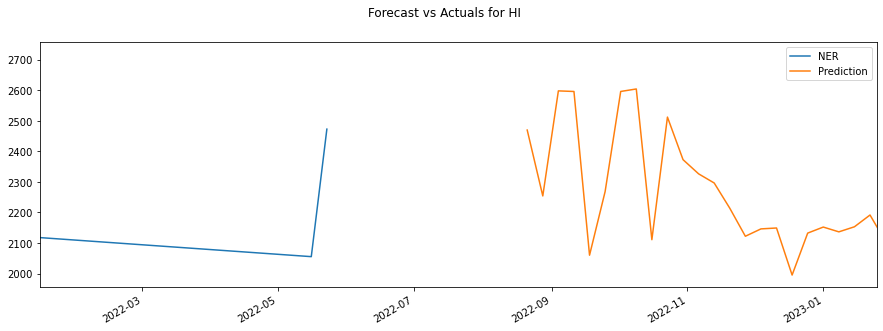

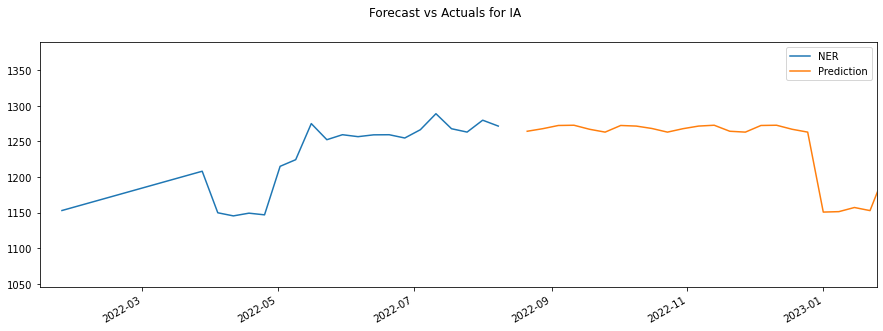

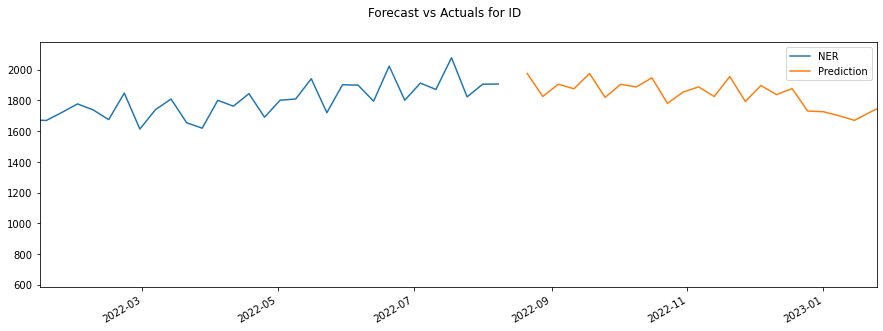

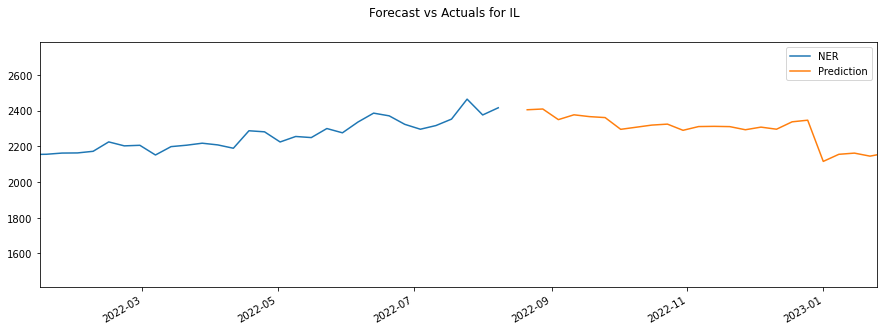

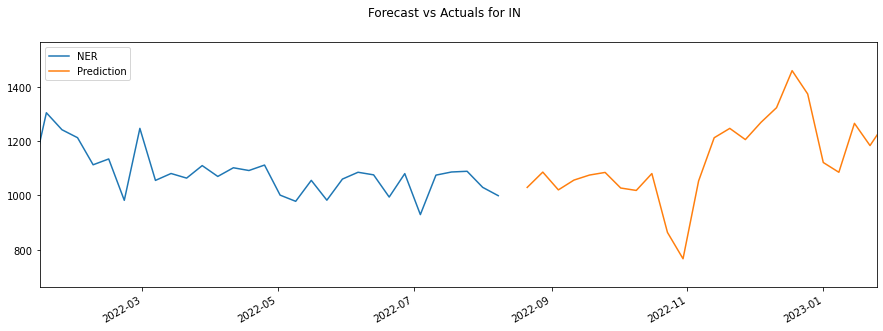

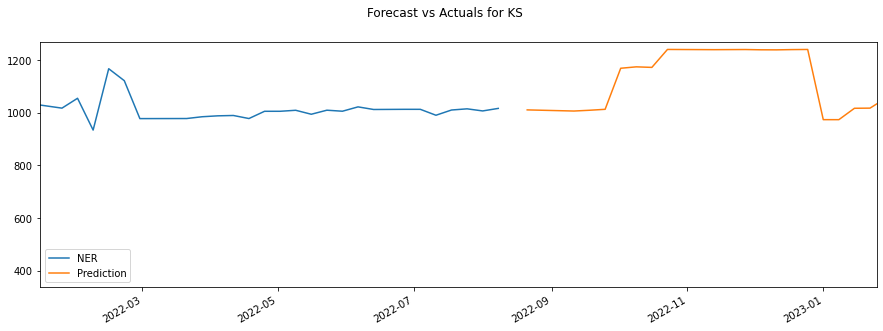

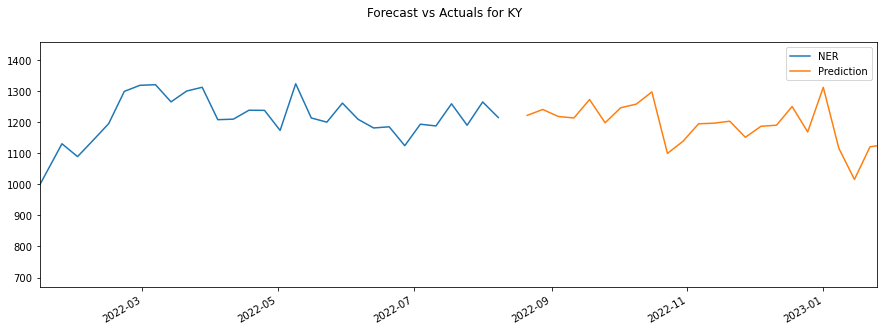

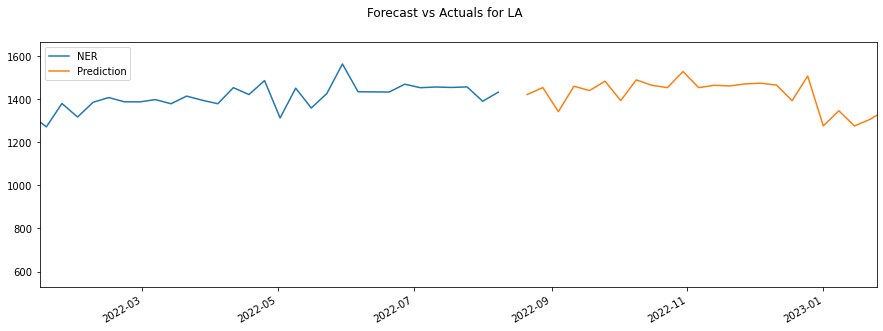

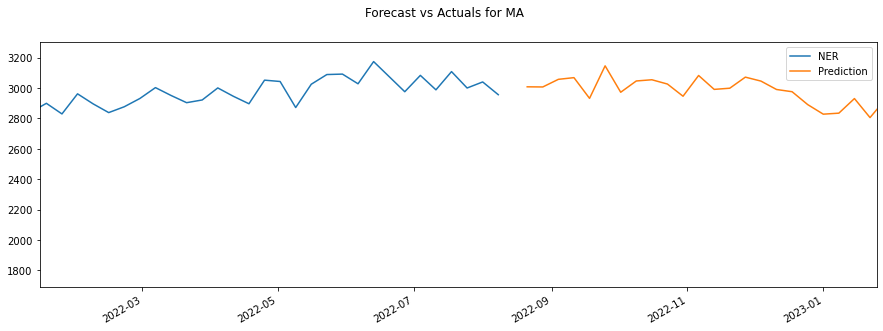

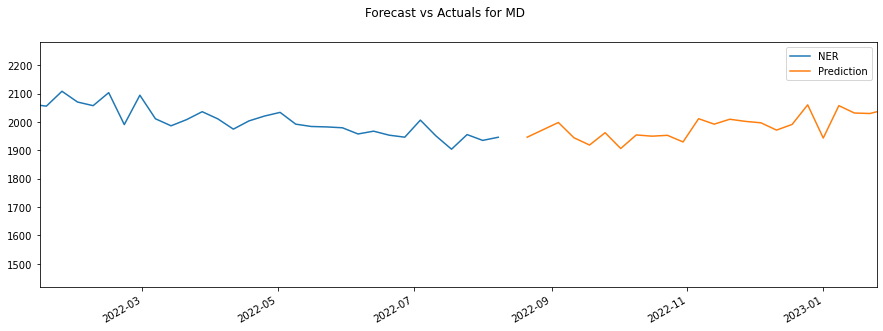

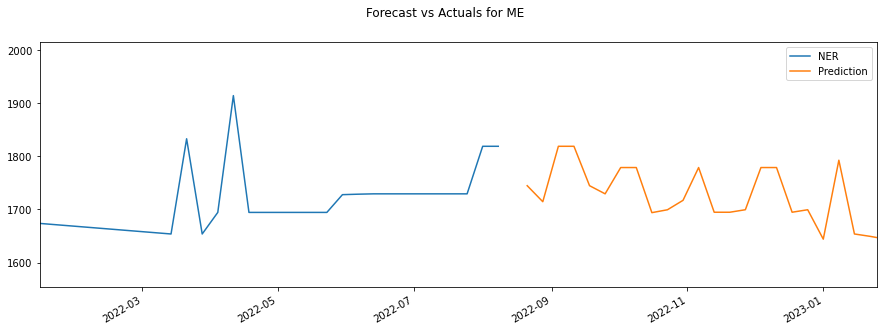

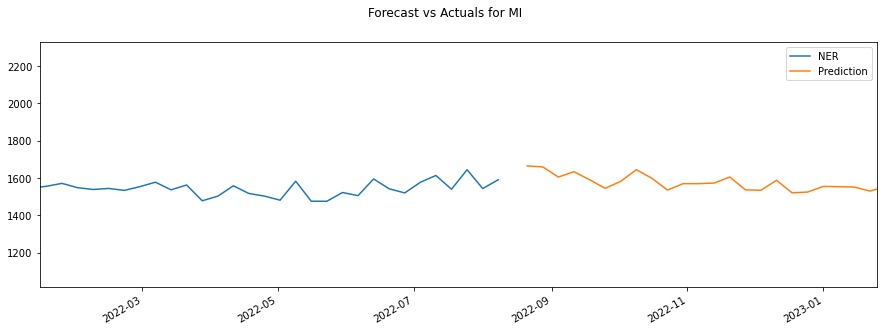

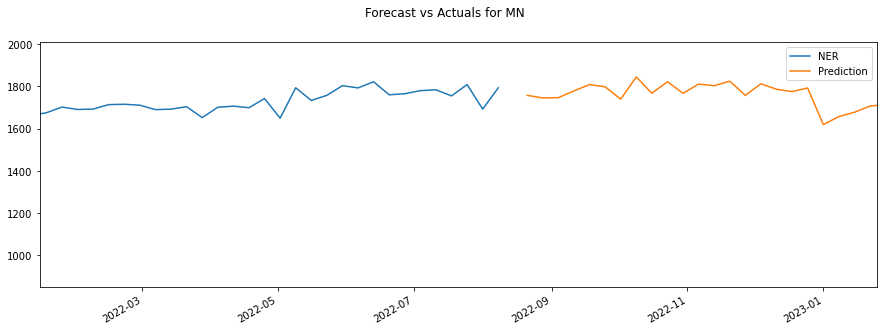

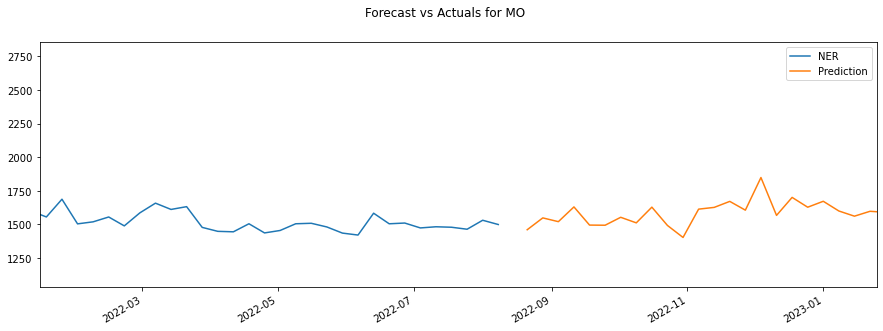

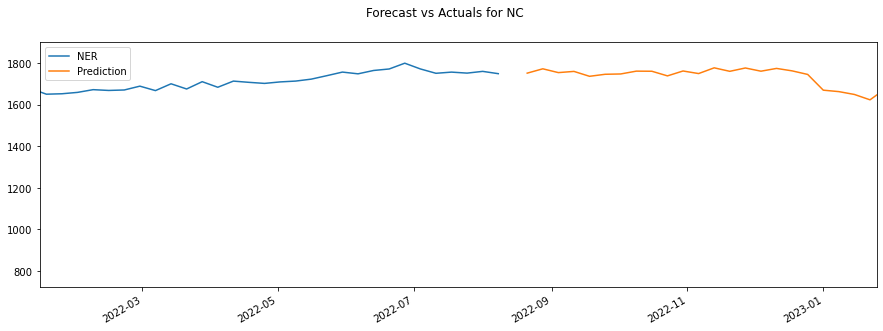

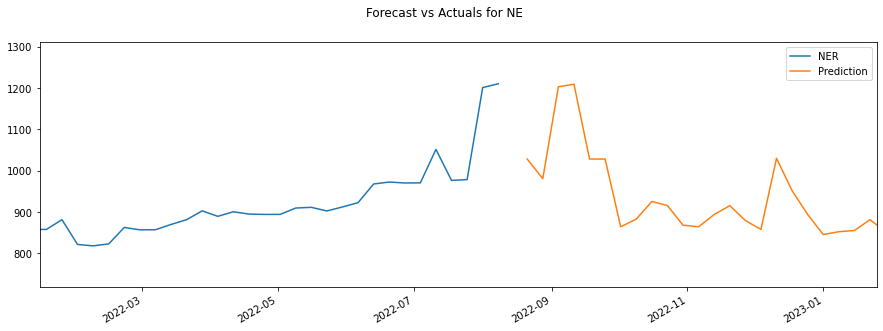

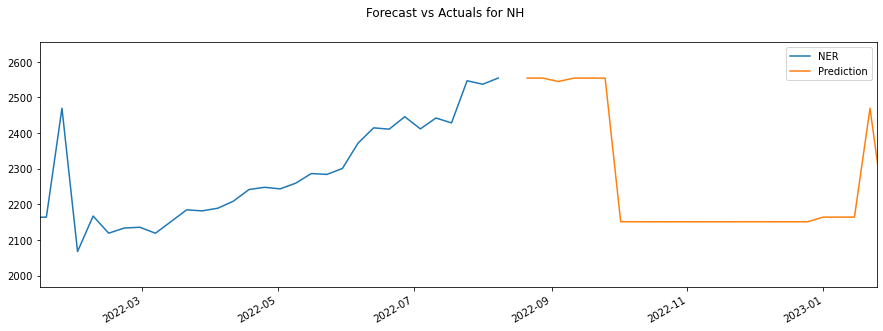

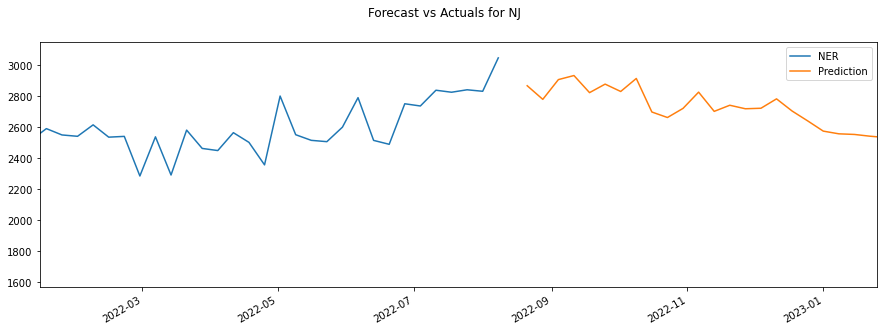

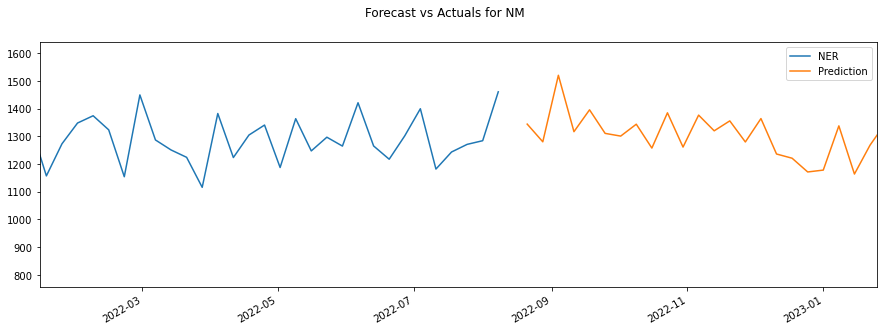

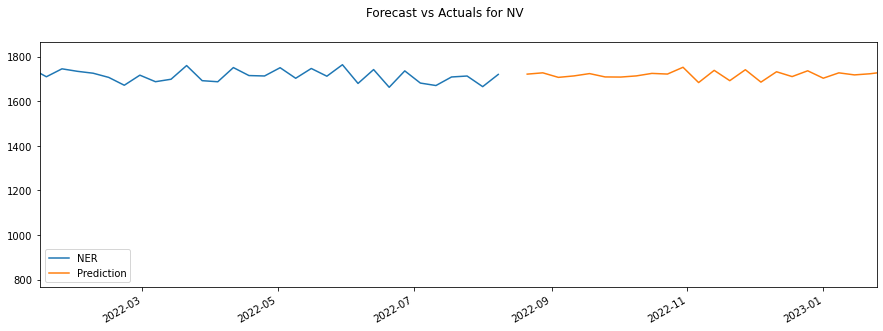

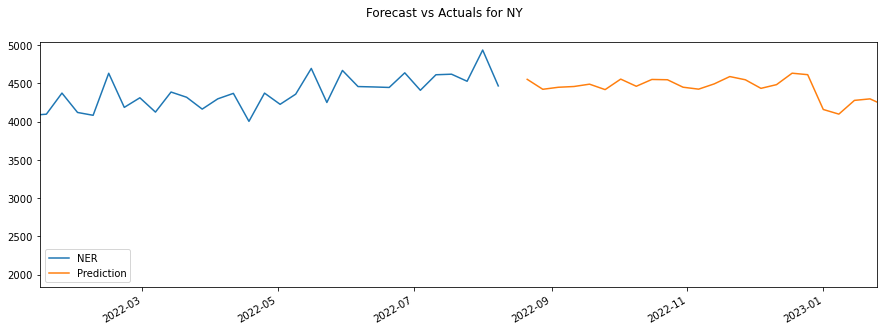

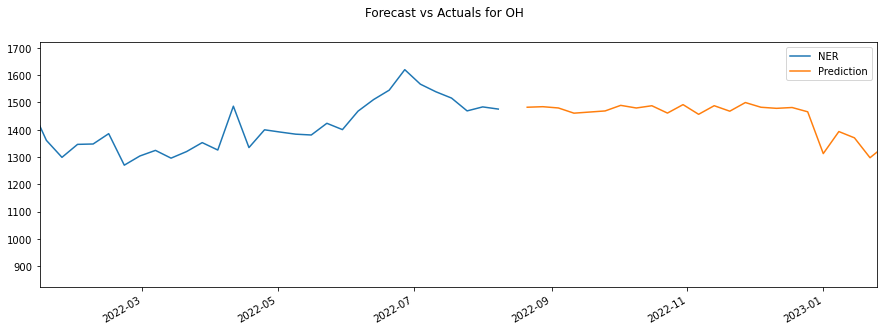

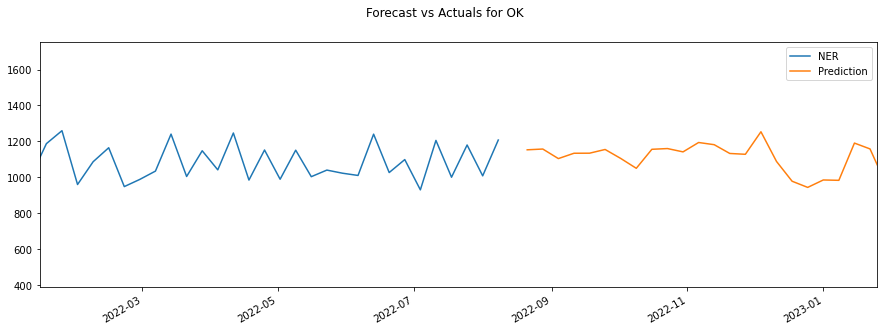

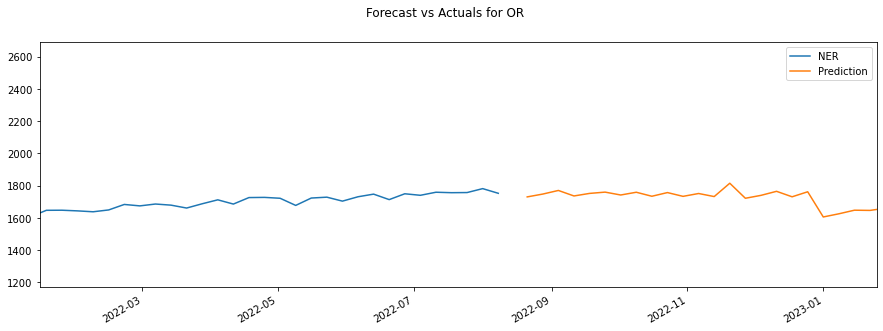

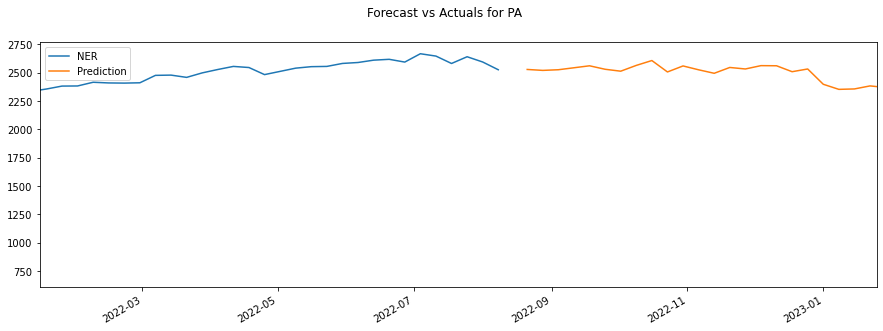

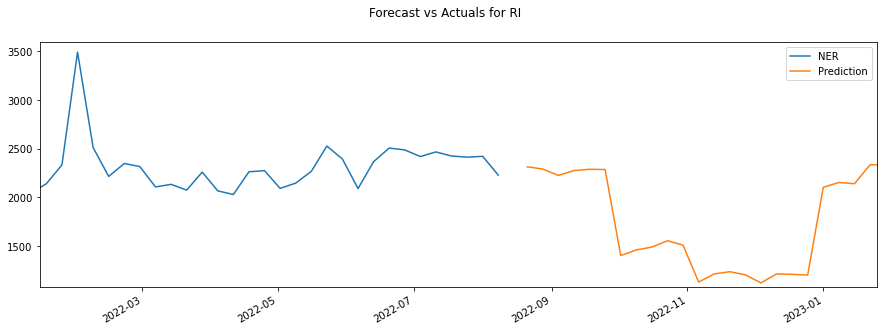

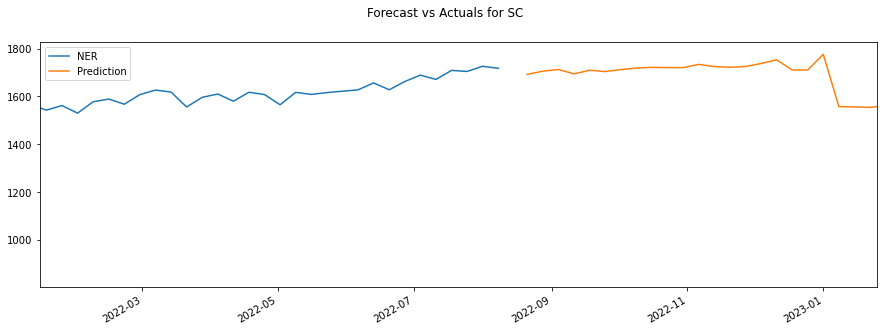

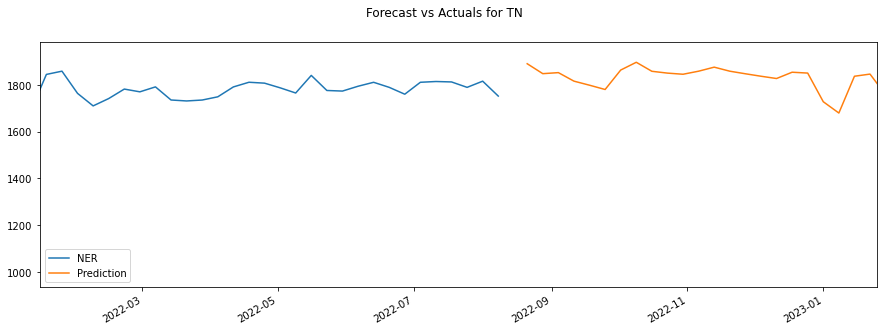

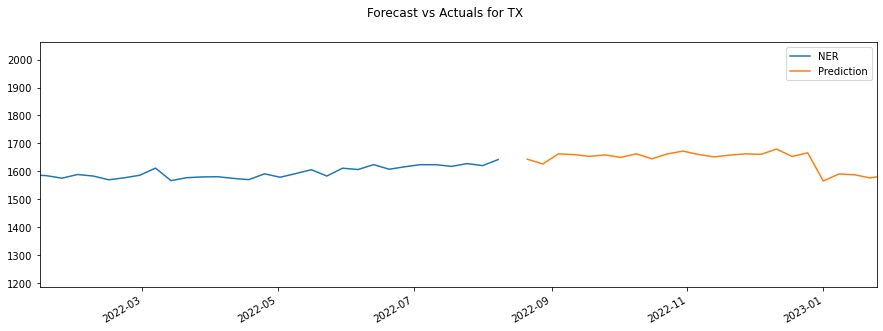

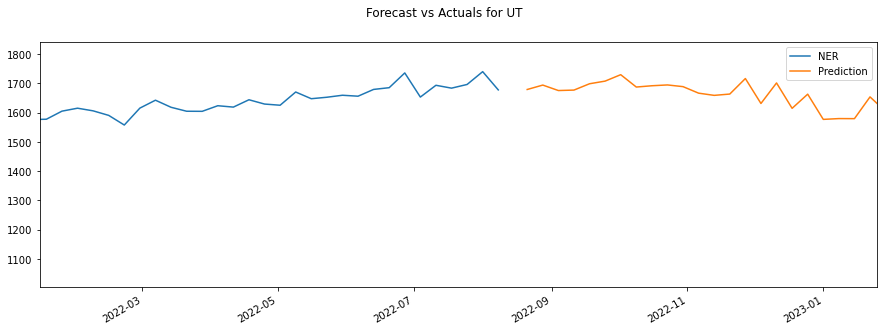

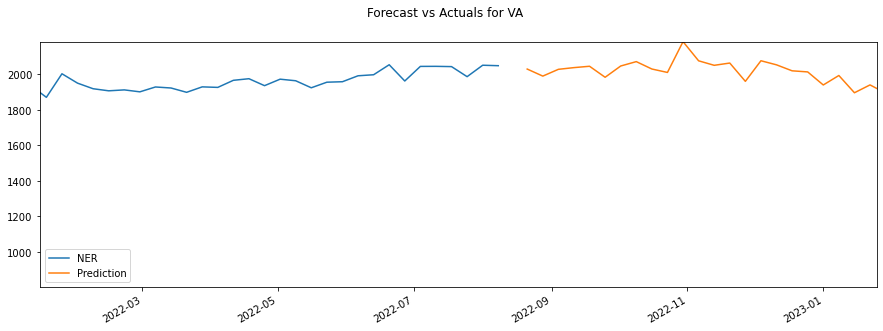

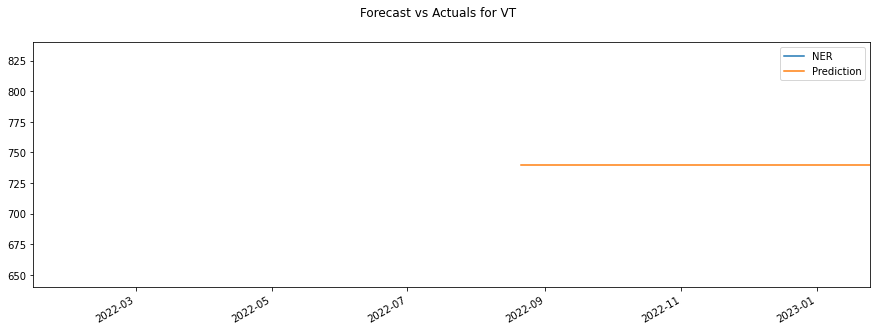

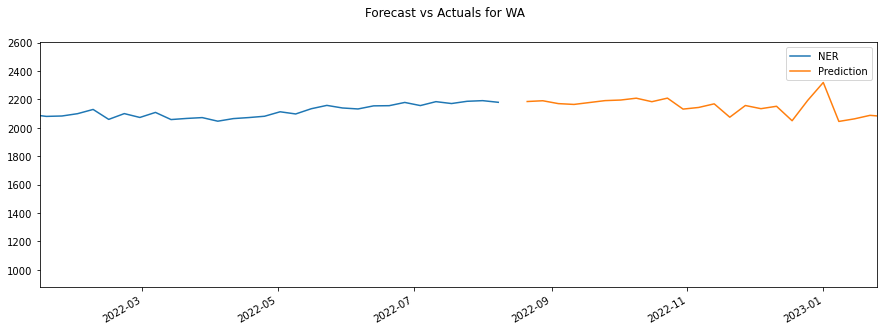

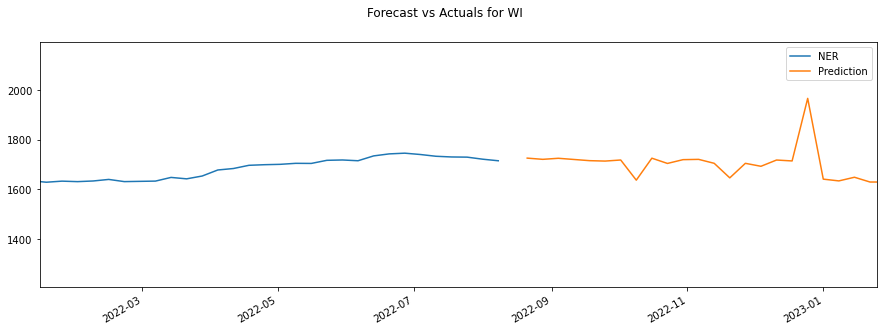

In [53]:
for unique_val, subset in subsets.items():
    subset['date'] = subset.index
    df_train = subset
    df_train = datetime_index(df_train, 'date')
    X_train, y_train = create_features(df_train, label='NER')
    
    
    prediction_period = pd.DataFrame(pd.date_range('2022-08-15', periods=24, freq='W'))
    prediction_period = prediction_period.rename(columns = {0:'date'})
    df_test = datetime_index(prediction_period, 'date')

    
    X_test = create_features(df_test)
    
    
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','-'])


    ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
    ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

    plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')

In [37]:
df_test.reset_index()['index']

0    2022-02-21
1    2022-02-28
2    2022-03-07
3    2022-03-14
4    2022-03-21
5    2022-03-28
6    2022-04-04
7    2022-04-11
8    2022-04-18
9    2022-04-25
10   2022-05-02
11   2022-05-09
12   2022-05-16
13   2022-05-23
14   2022-05-30
15   2022-06-06
16   2022-06-13
17   2022-06-20
18   2022-06-27
19   2022-07-04
20   2022-07-11
21   2022-07-18
22   2022-07-25
23   2022-08-01
24   2022-08-08
Name: index, dtype: datetime64[ns]

In [35]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])
msa_data_lst

['Atlanta, GA',
 'Austin, TX',
 'Baltimore, MD',
 'Boston, MA',
 'Charleston, SC',
 'Charlotte, NC',
 'Chicago, IL',
 'Dallas, TX',
 'Denver, CO',
 'Houston, TX',
 'Jacksonville, FL',
 'Las Vegas, NV',
 'Los Angeles, CA',
 'Miami, FL',
 'Nashville, TN',
 'New York, NY',
 'Orlando, FL',
 'Phoenix, AZ',
 'Portland, OR',
 'Raleigh, NC',
 'Riverside, CA',
 'San Antonio, TX',
 'San Diego, CA',
 'San Francisco, CA',
 'San Jose, CA',
 'Seattle, WA',
 'Tampa, FL',
 'Washington, DC']

In [27]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER')

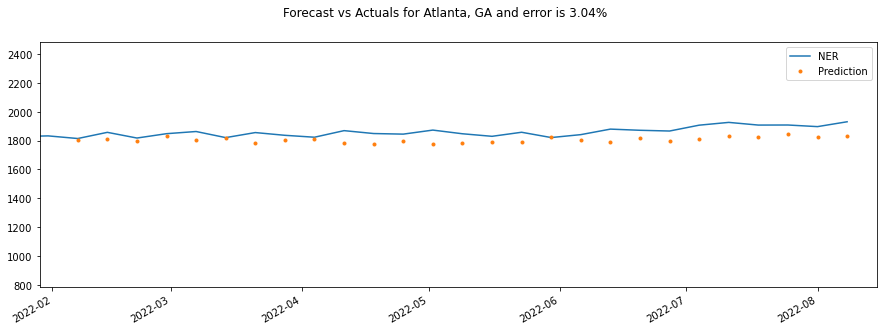

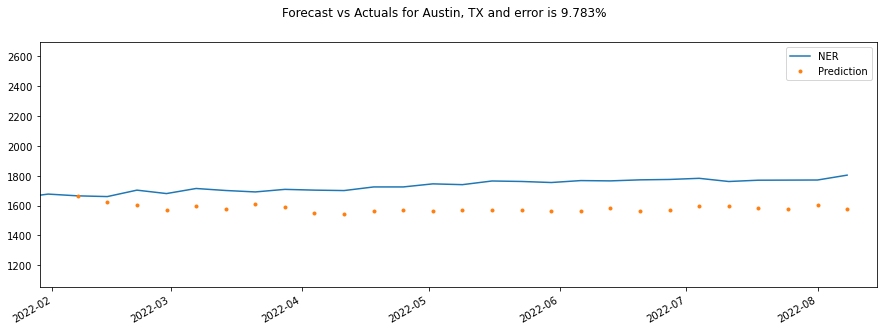

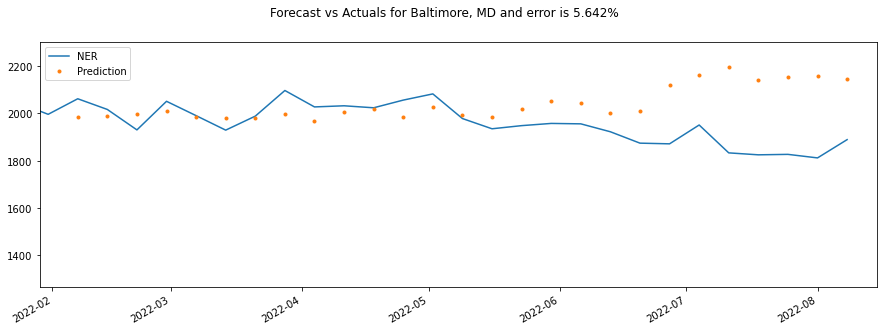

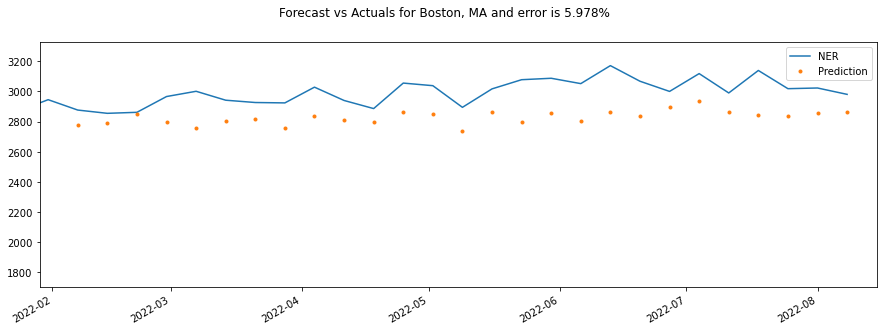

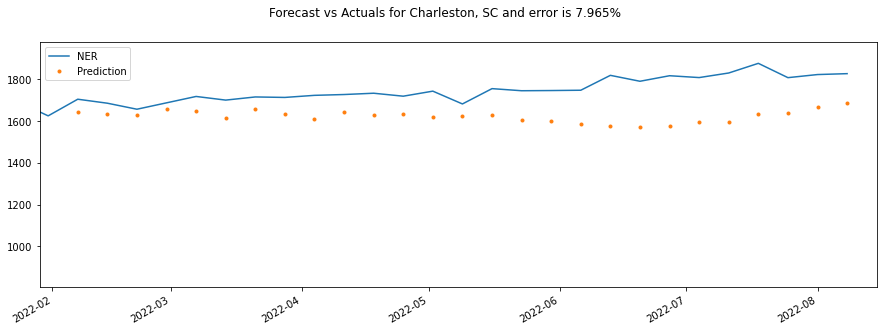

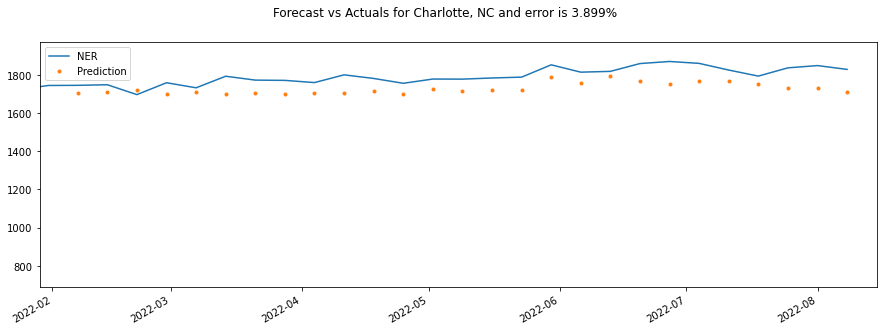

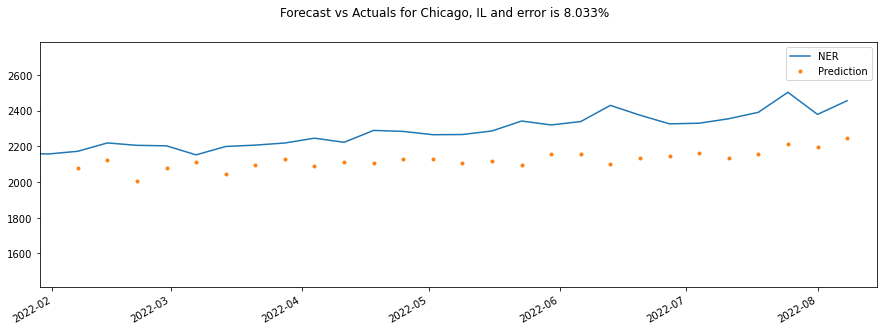

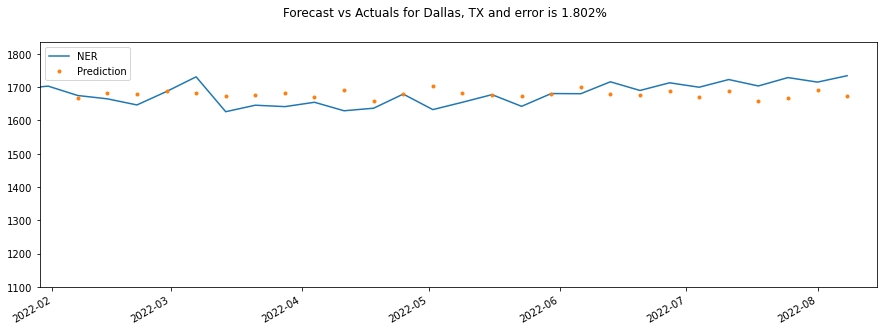

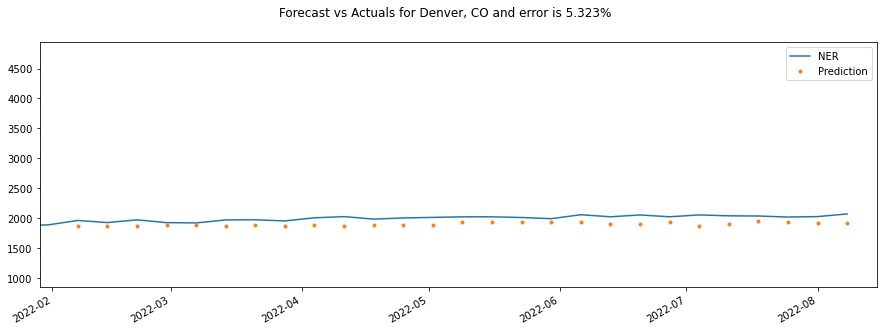

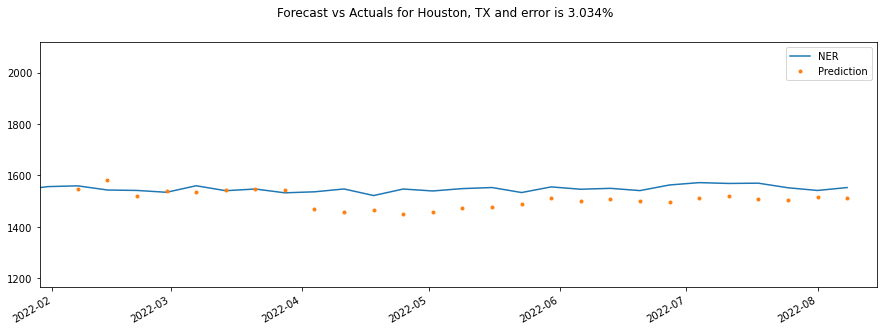

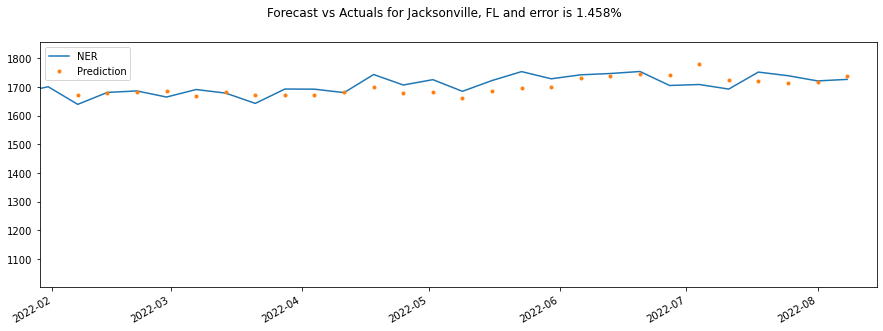

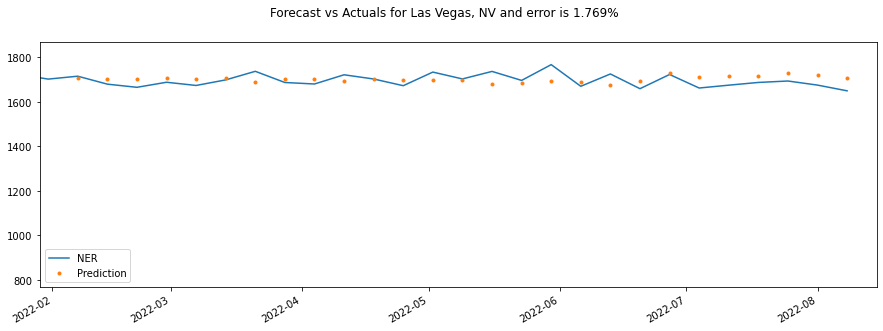

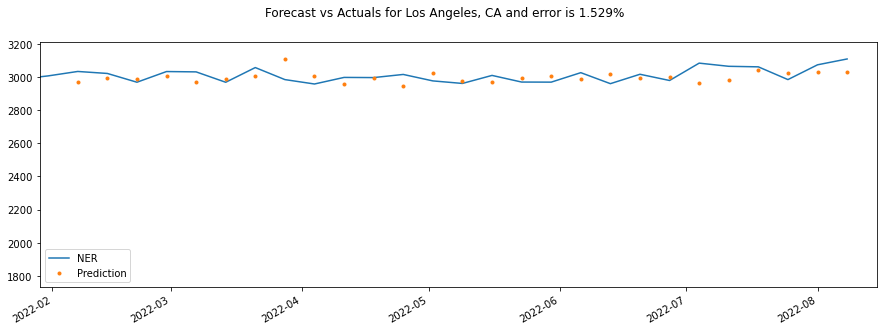

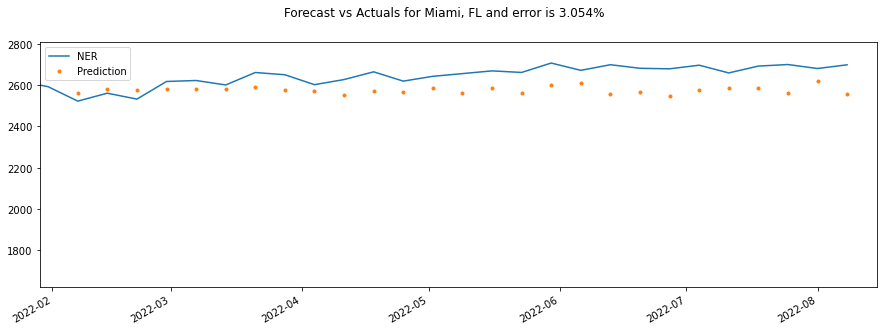

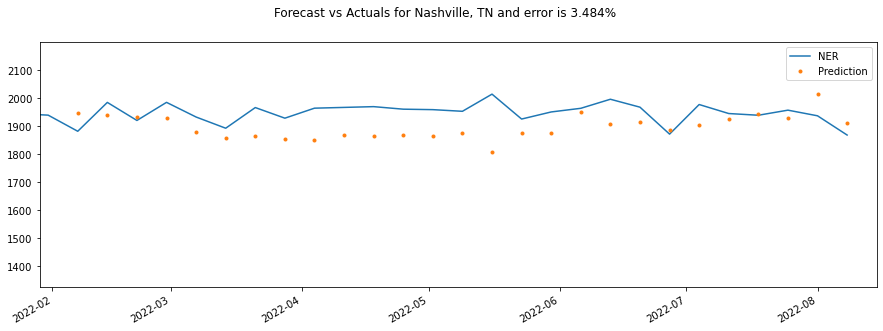

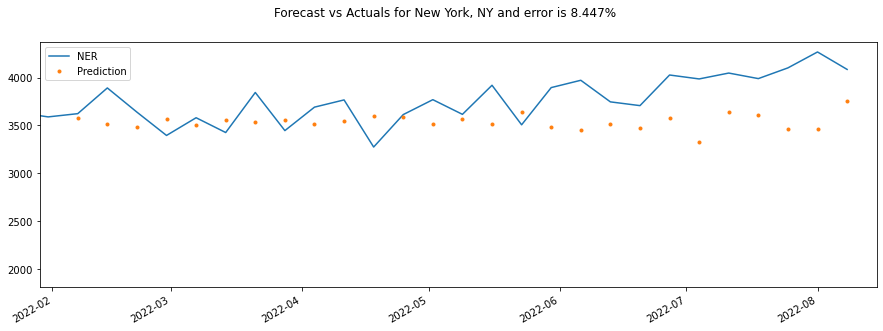

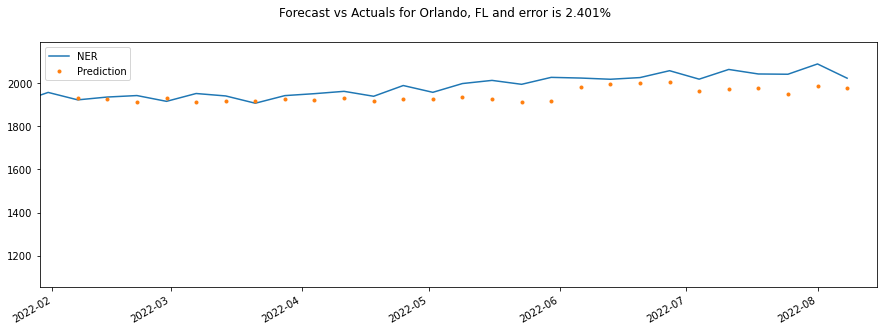

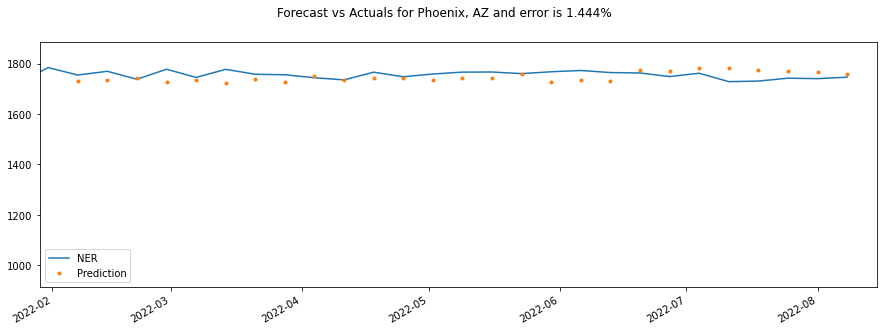

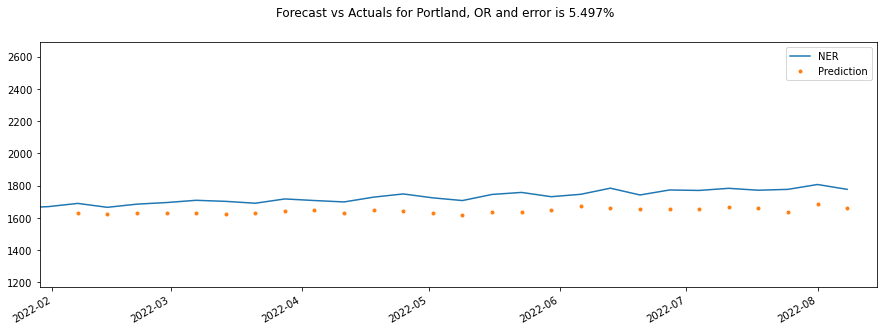

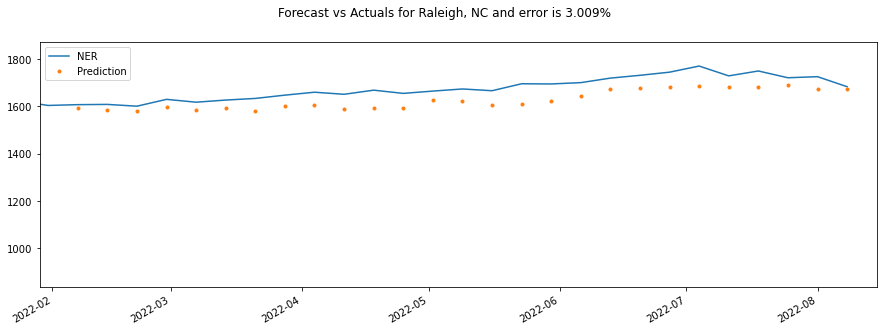

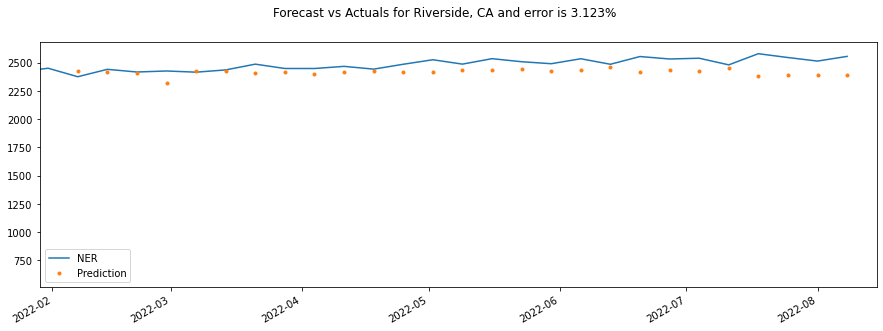

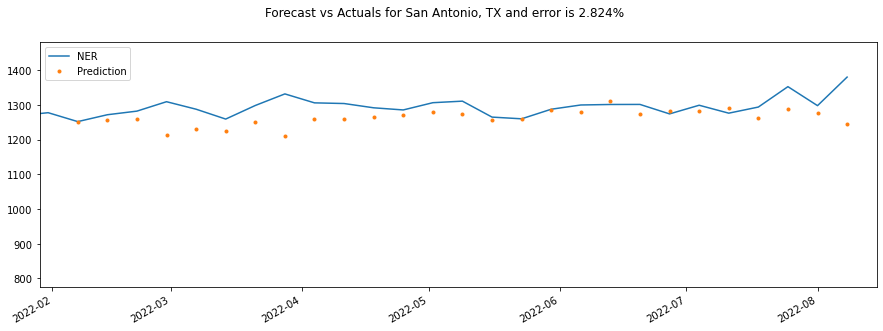

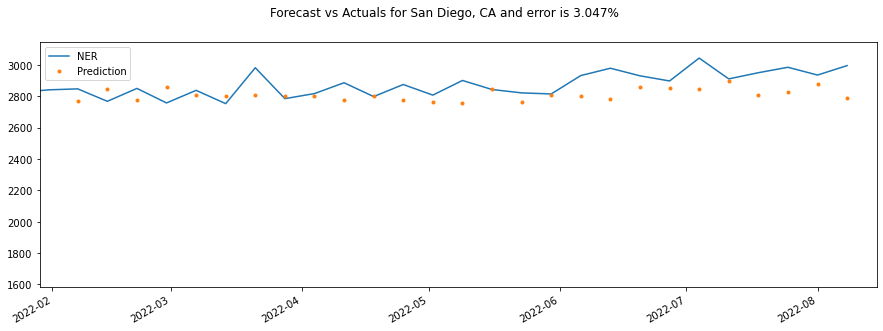

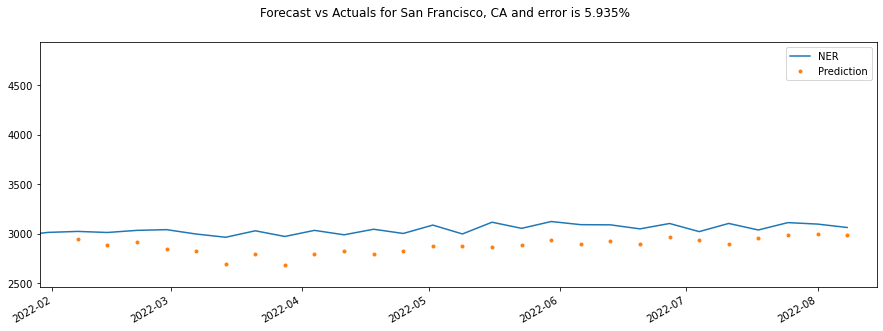

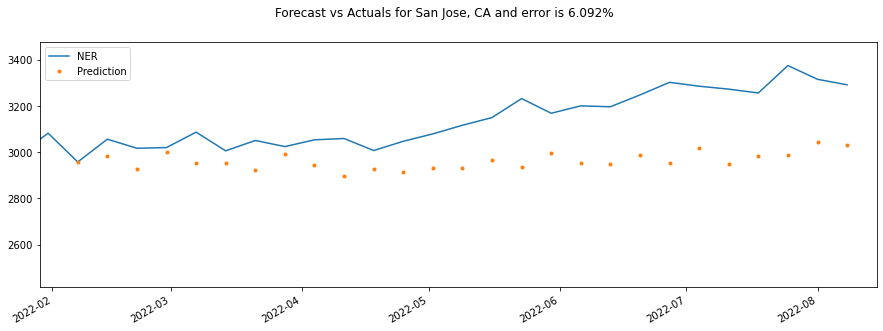

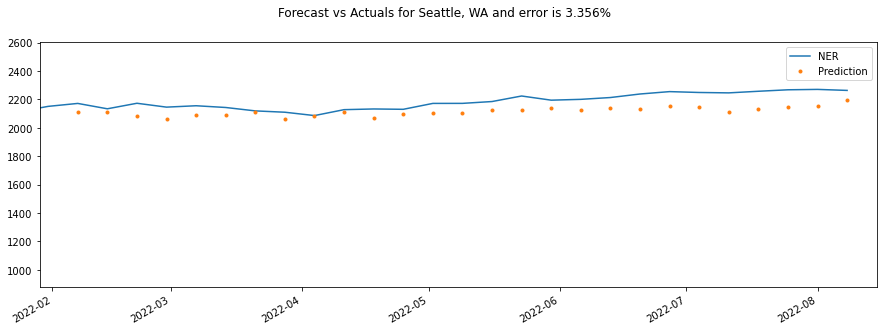

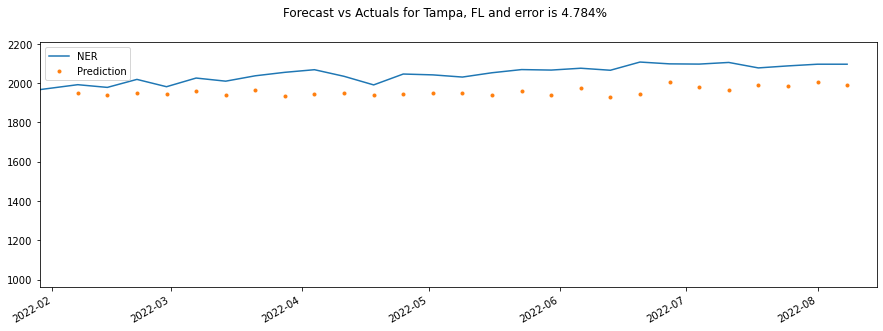

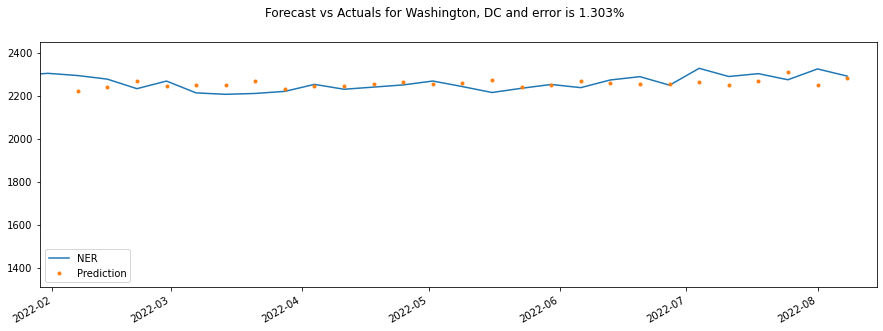

In [28]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        split_date = date(2022, 2, 1)
        subset['date'] = subset.index
        df_train = subset.loc[subset.index <= split_date].copy()
        df_test = subset.loc[subset.index > split_date].copy()
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        X_train, y_train = create_features(df_train, label='NER')

        X_test, y_test = create_features(df_test, label='NER')
        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape = evaluation(df_test['NER'], df_test['Prediction'])

        if mape < 0.10:
            f, ax = plt.subplots(1)
            f.set_figheight(5)
            f.set_figwidth(15)
            _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','.'])


            ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
            ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

            plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

**Extracting the data into a df**

In [54]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
        print(unique_val)
        print(subset.tail(25))

Atlanta, GA
                 UNITS          NER        date
WEEK_START                                     
2022-02-21  314.030303  1817.921198  2022-02-21
2022-02-28  309.082803  1848.099796  2022-02-28
2022-03-07  312.276265  1863.197080  2022-03-07
2022-03-14  305.674180  1820.822218  2022-03-14
2022-03-21  310.052124  1855.841432  2022-03-21
2022-03-28  307.829615  1836.854901  2022-03-28
2022-04-04  307.003922  1823.529184  2022-04-04
2022-04-11  309.259574  1869.241048  2022-04-11
2022-04-18  305.550098  1849.126363  2022-04-18
2022-04-25  308.770751  1845.033600  2022-04-25
2022-05-02  304.528376  1873.052152  2022-05-02
2022-05-09  301.965138  1847.576955  2022-05-09
2022-05-16  306.468750  1829.851973  2022-05-16
2022-05-23  305.926874  1857.976089  2022-05-23
2022-05-30  306.693712  1821.246608  2022-05-30
2022-06-06  310.824869  1841.506493  2022-06-06
2022-06-13  309.597701  1879.796711  2022-06-13
2022-06-20  307.283333  1871.717768  2022-06-20
2022-06-27  303.220952  1866

In [55]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_xgboost = pd.DataFrame(columns = column_names)
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [56]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)

                
        algorithm_name = 'XGBoost Model'
        
        ## experimenting with a dataset
        prediction_period = 25
        
        
        df_train = subset[:-prediction_period]
        df_test = subset[-prediction_period:]
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        
        X_train, y_train = create_features(df_train, label='NER')
        X_test, y_test = create_features(df_test, label='NER')
        
        
        reg = xgb.XGBRegressor(n_estimators=500)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape_score = evaluation(df_test['NER'], df_test['Prediction'])

                
        #print(df_test.reset_index()['index'])
        
        df['Actuals'] =  df_test['NER']
        df['Predictions'] =  df_test['Prediction']
        df['MAPE score'] =  mape_score
        df['Time'] =  list(df_test.reset_index()['index'])
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        df_xgboost = df_xgboost.append(df, ignore_index=True)

In [57]:
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,XGBoost Model,2022-02-21,"Atlanta, GA",1817.921198,1810.356934,0.026886
1,XGBoost Model,2022-02-28,"Atlanta, GA",1848.099796,1832.981567,0.026886
2,XGBoost Model,2022-03-07,"Atlanta, GA",1863.197080,1812.256348,0.026886
3,XGBoost Model,2022-03-14,"Atlanta, GA",1820.822218,1841.191772,0.026886
4,XGBoost Model,2022-03-21,"Atlanta, GA",1855.841432,1796.992188,0.026886
...,...,...,...,...,...,...
695,XGBoost Model,2022-07-11,"Washington, DC",2289.162759,2264.670166,0.015005
696,XGBoost Model,2022-07-18,"Washington, DC",2302.472282,2267.269531,0.015005
697,XGBoost Model,2022-07-25,"Washington, DC",2274.104898,2291.549805,0.015005
698,XGBoost Model,2022-08-01,"Washington, DC",2324.496021,2238.745117,0.015005


In [59]:
df_xgboost.to_csv("df_xgboost_msa_level.csv")

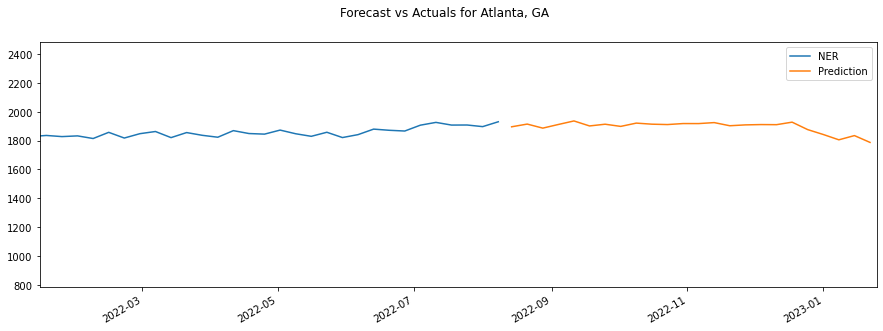

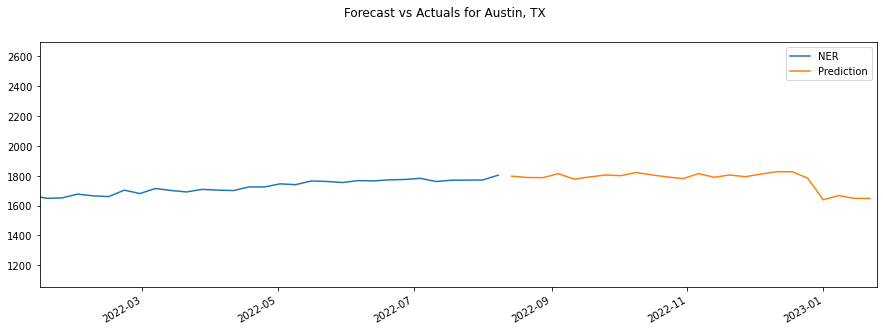

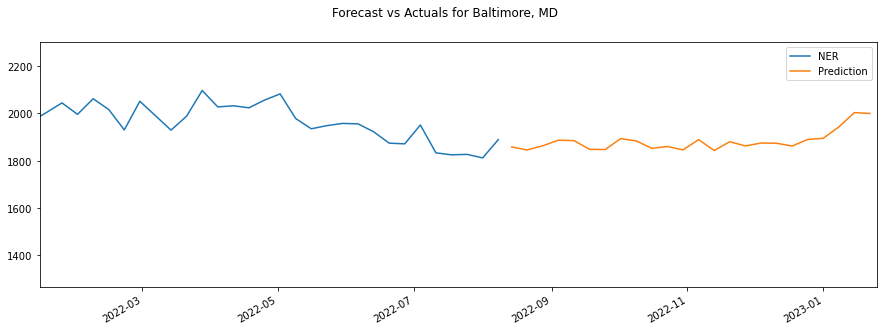

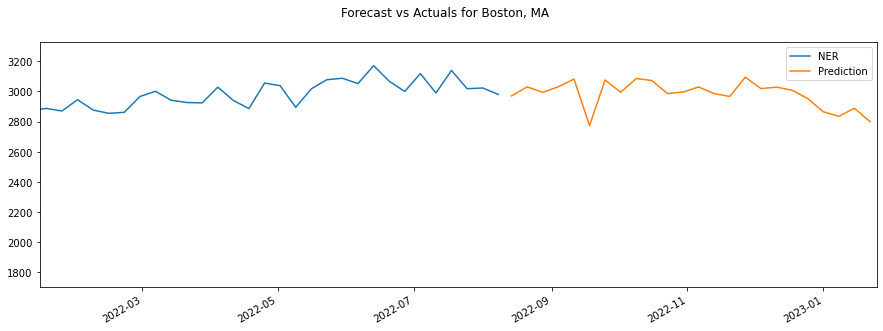

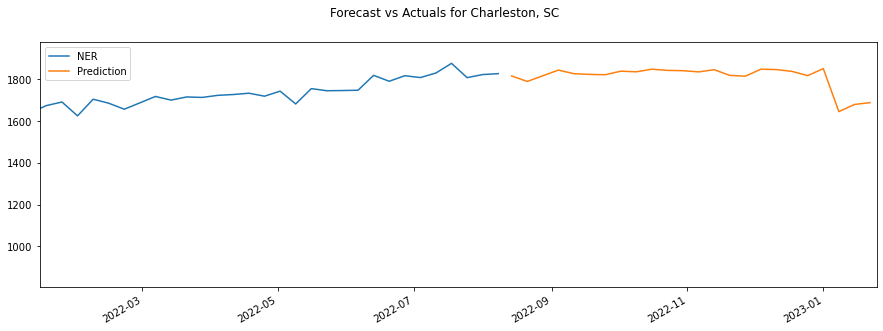

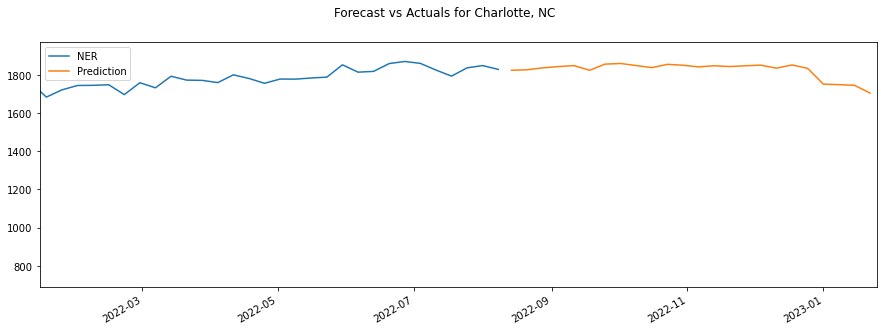

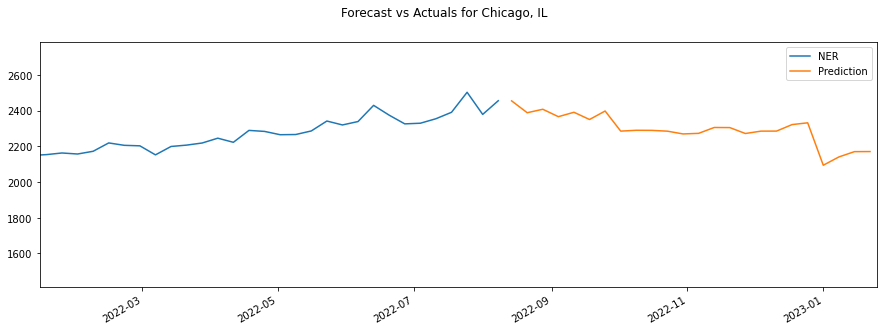

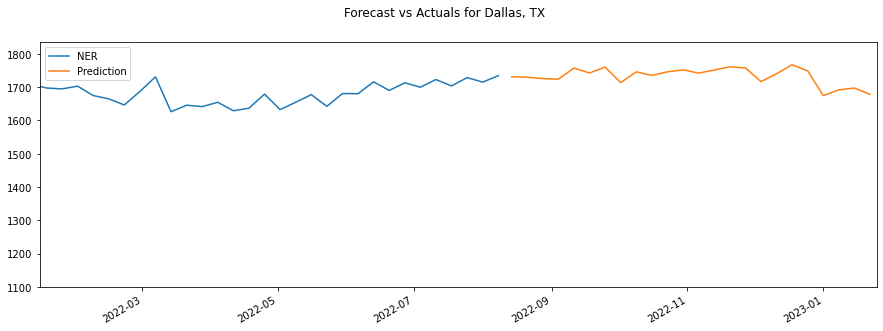

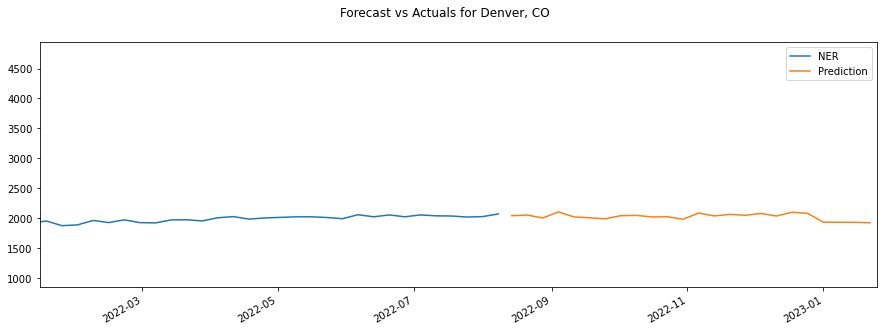

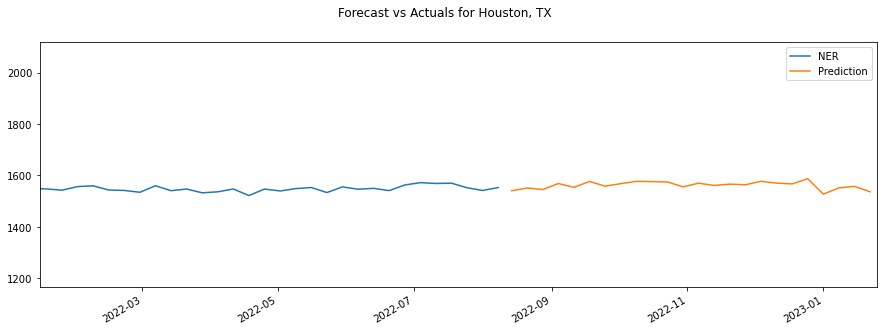

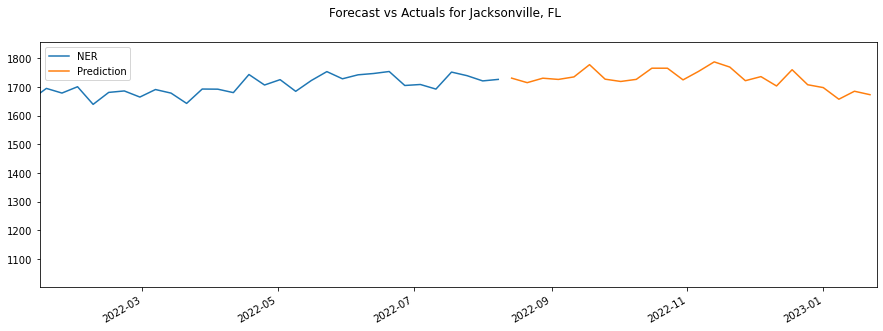

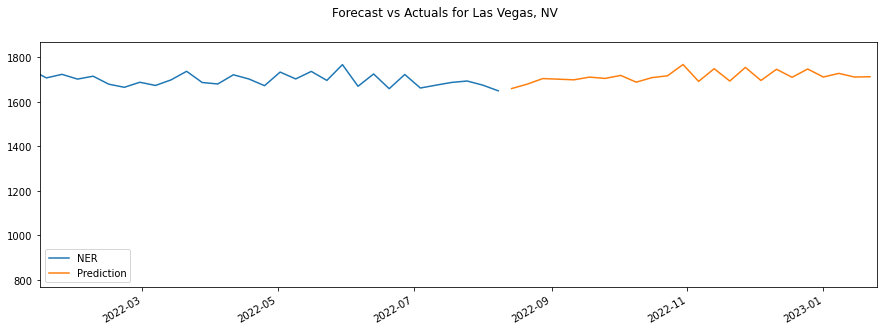

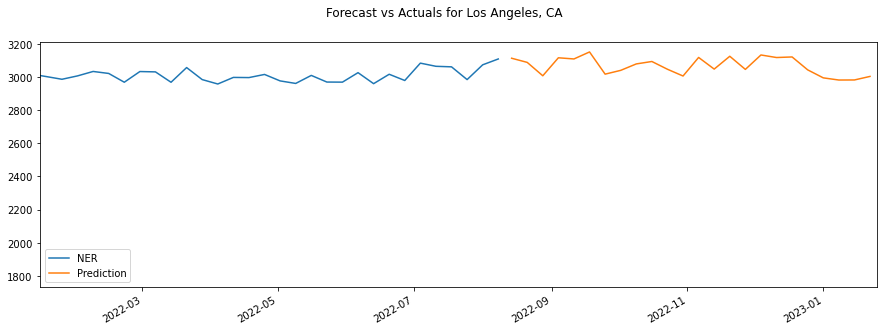

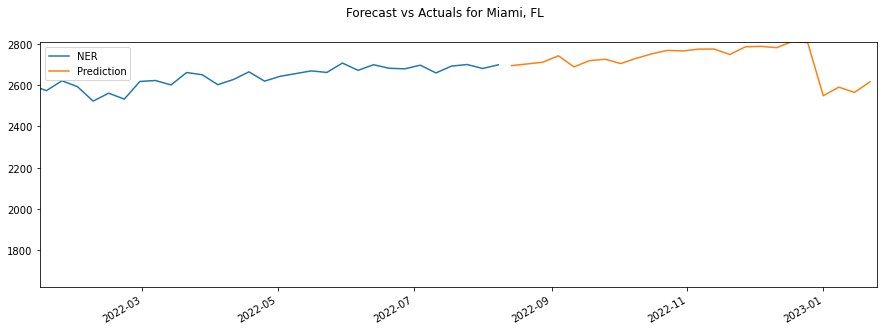

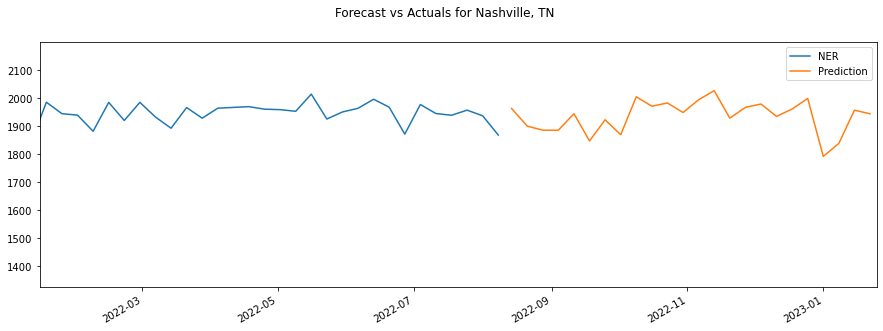

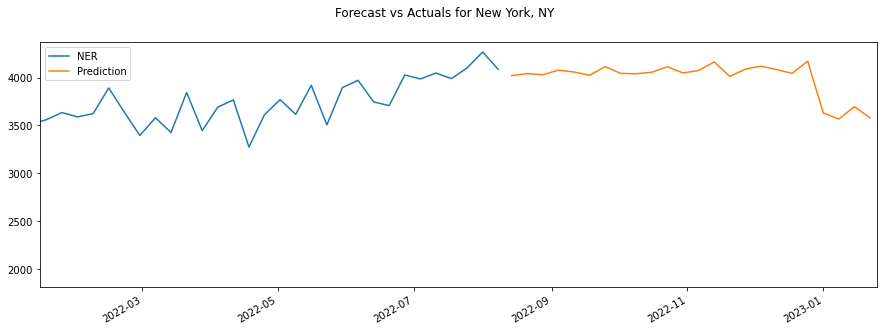

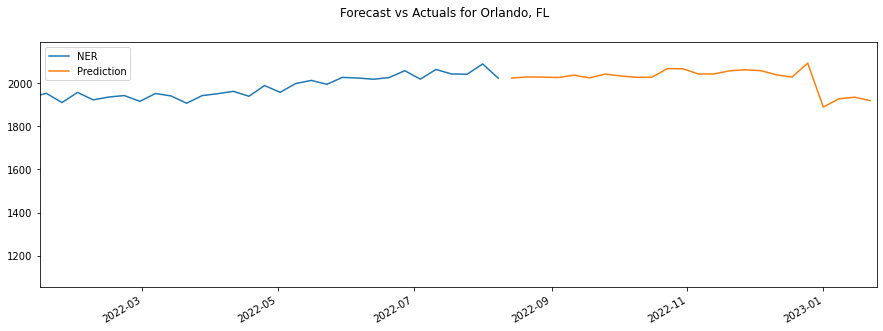

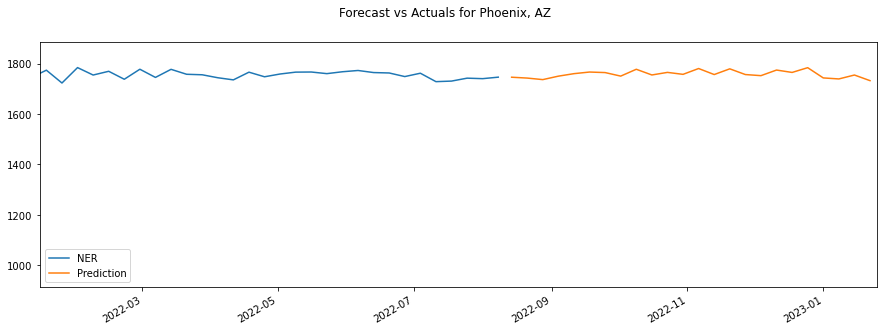

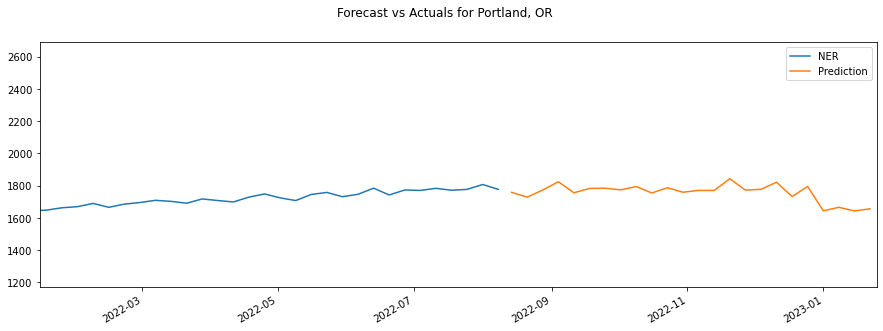

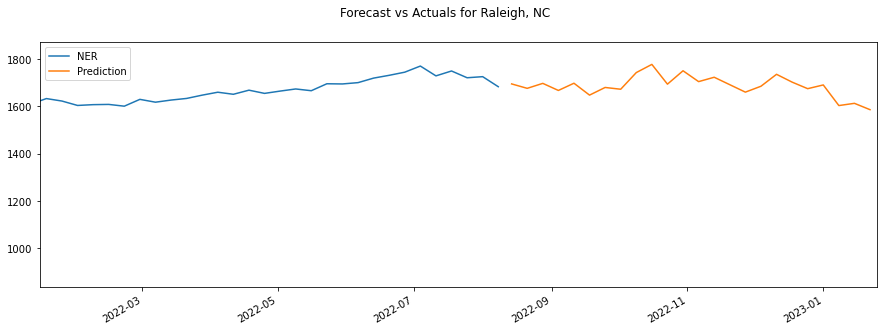

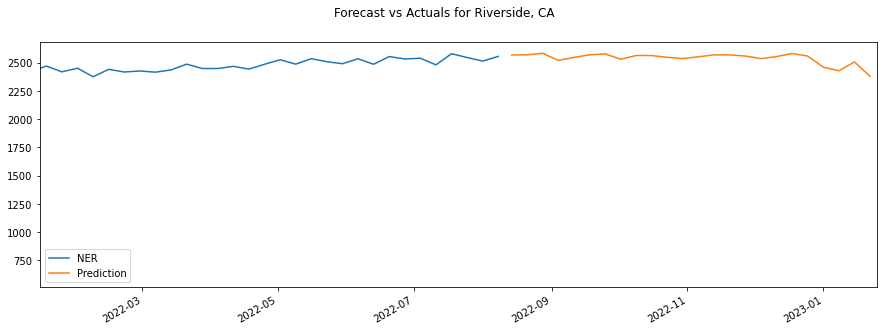

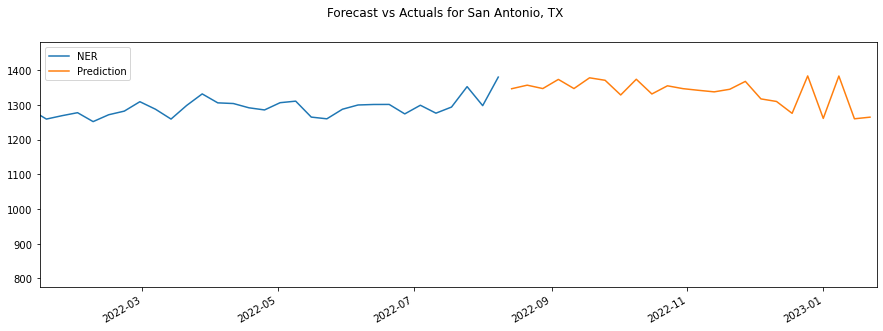

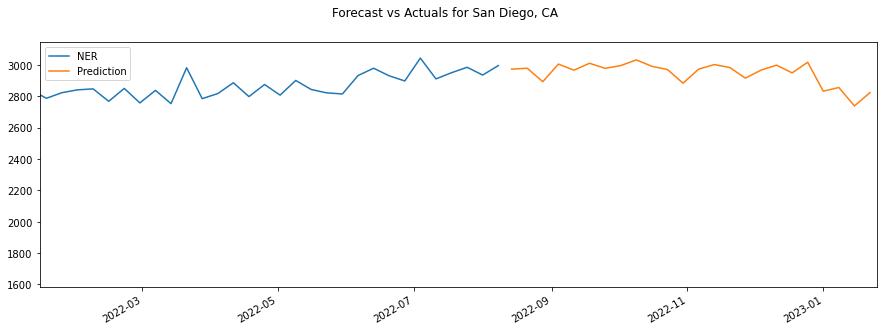

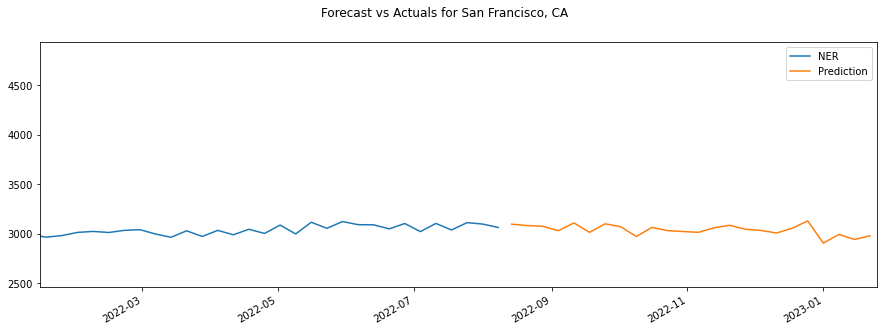

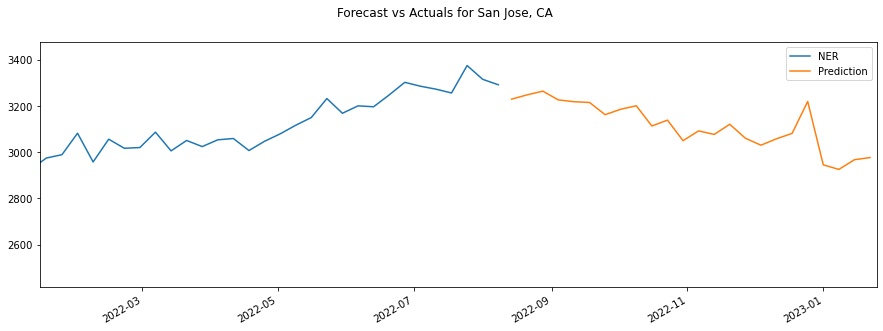

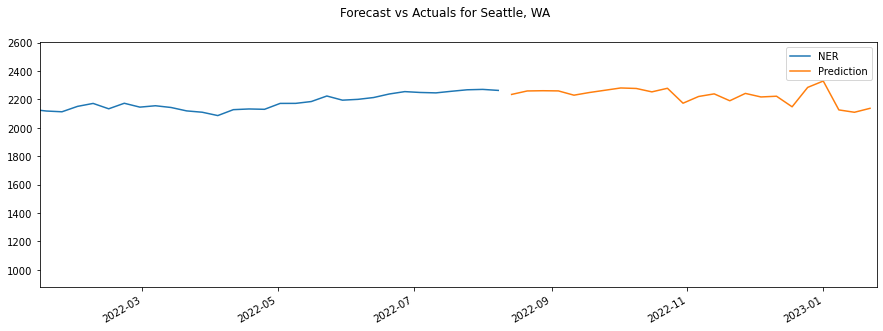

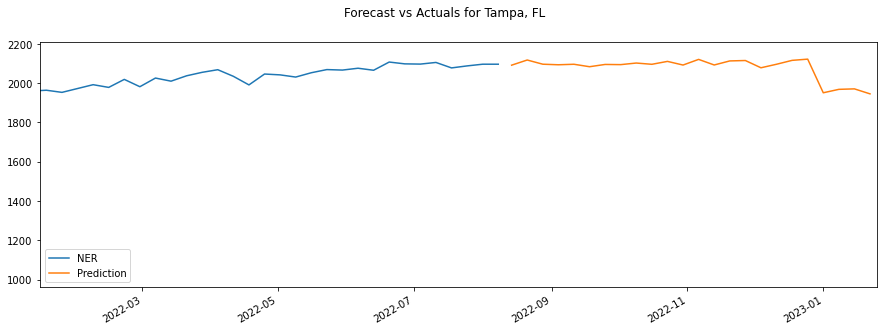

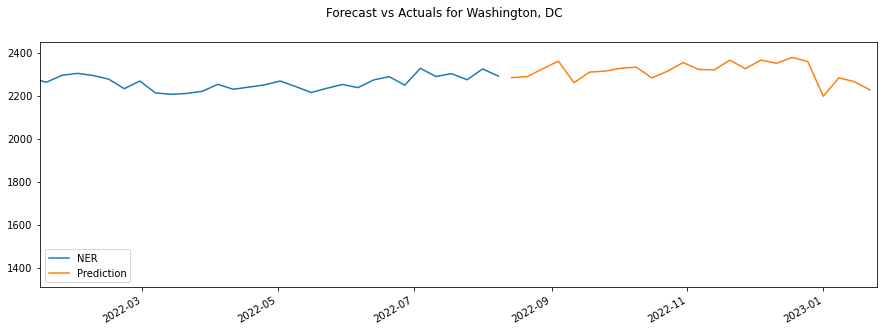

In [58]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        subset['date'] = subset.index
        df_train = subset
        df_train = datetime_index(df_train, 'date')
        X_train, y_train = create_features(df_train, label='NER')


        prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
        prediction_period = prediction_period.rename(columns = {0:'date'})
        df_test = datetime_index(prediction_period, 'date')


        X_test = create_features(df_test)


        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)


        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','-'])


        ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
        ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')